# 🎯 Label Noise Injection Ablation Study
## Reputation-Based FL vs Standard FL Under Attack

**Scenario:** Simulating real-world WBAN data quality issues
- Client 1: Clean (0% noise)
- Client 2: Low noise (10% label flips)
- Client 3: Medium noise (30% label flips)
- Client 4: High noise/Malicious (50% label flips)
- Client 5: Clean (0% noise)

**Comparison:**
- ❌ Baseline: Standard FedAvg (no reputation filtering)
- ✅ Proposed: Reputation-weighted FedAvg (with filtering)

STEP 1: LOADING SECURECARE WBAN DATASET
✓ Dataset loaded: (72094, 4)
✓ Classes: ['Sitting' 'Speak and Walk' 'Speaking' 'Staying' 'Walking']
✓ Class distribution:
Class
0     9560
1    18673
2    12867
3    16453
4    14541
Name: count, dtype: int64

STEP 2: EXTRACTING WINDOWED FEATURES
✓ Features extracted: (1125, 17)

STEP 3: SPLITTING AND NORMALIZING DATA
✓ Train samples: 900
✓ Test samples: 225
✓ Number of classes: 5

STEP 4: DEFINING LABEL NOISE INJECTION
✓ Label noise injection function defined

STEP 5: CREATING FEDERATED CLIENTS WITH VARYING NOISE LEVELS
Client 1: 180 samples | Target noise: 0% | Actual noise: 0.0%
Client 2: 180 samples | Target noise: 10% | Actual noise: 10.0%
Client 3: 180 samples | Target noise: 30% | Actual noise: 30.0%
Client 4: 180 samples | Target noise: 50% | Actual noise: 50.0%
Client 5: 180 samples | Target noise: 0% | Actual noise: 0.0%

STEP 6: DEFINING MODEL ARCHITECTURE
✓ Model architecture: XGBoost + RandomForest ensemble (soft voting)

STEP 7: DEF

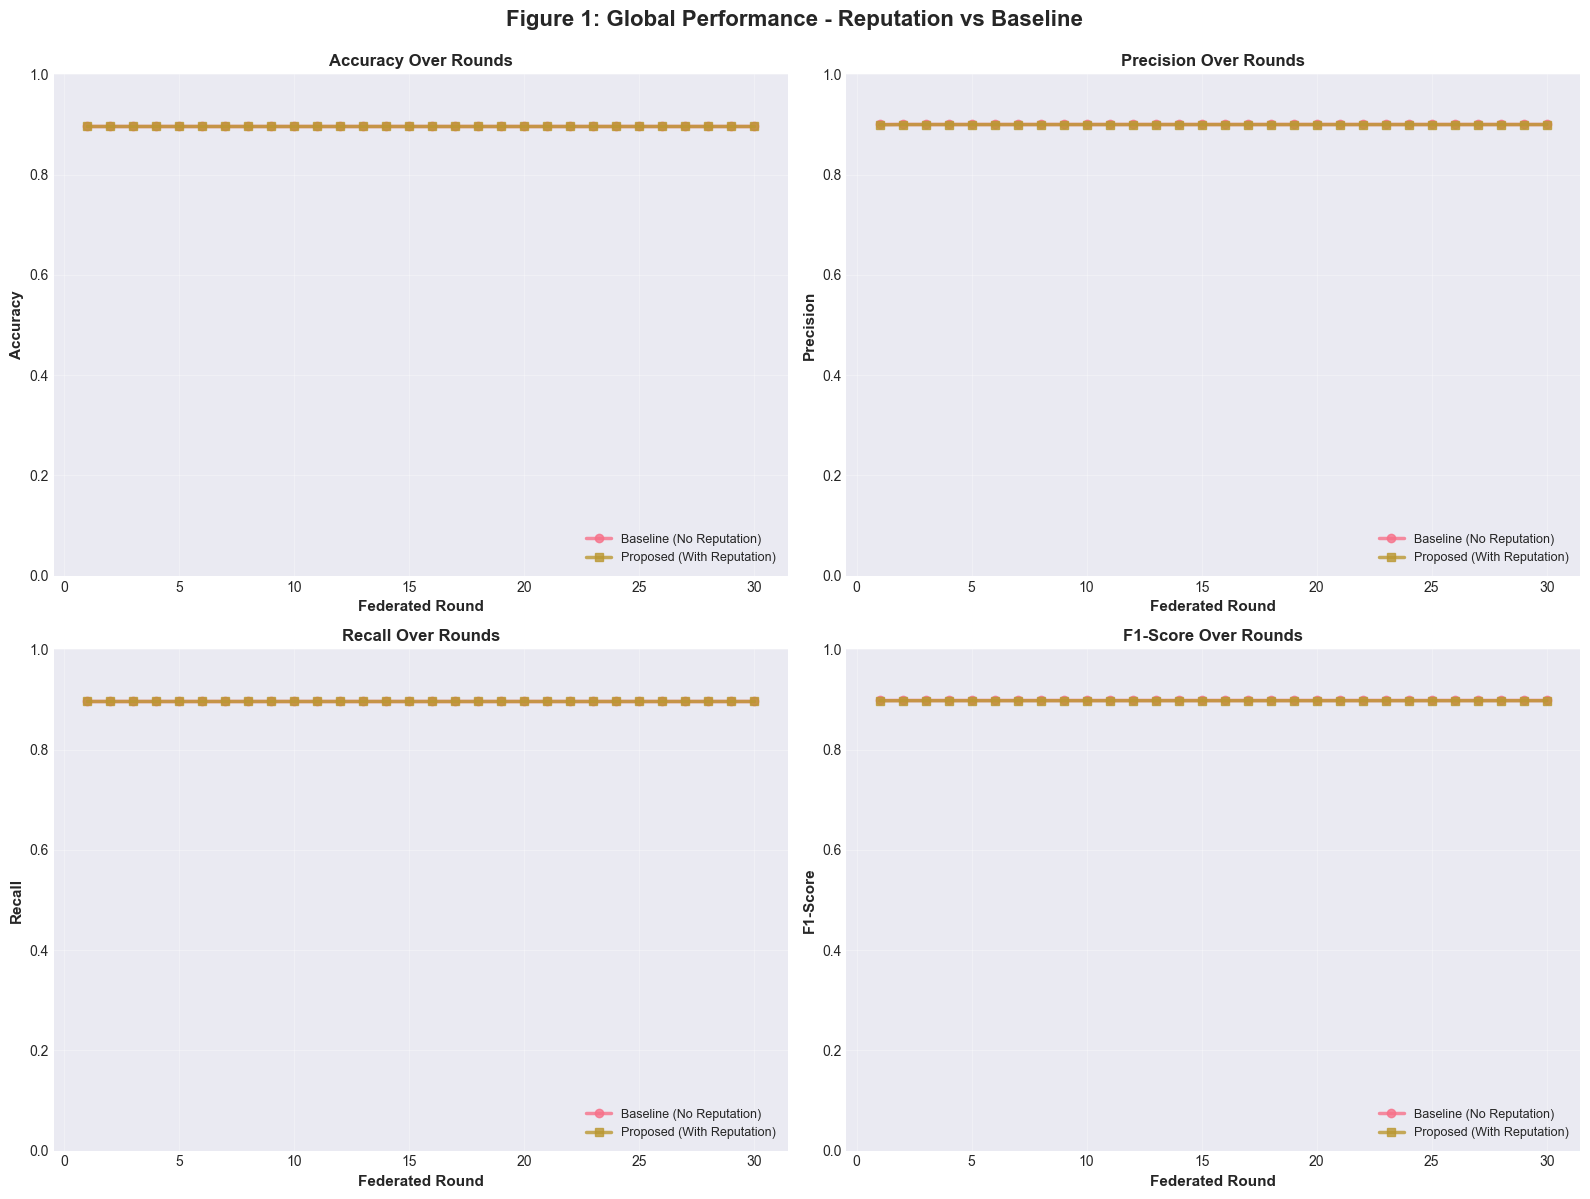

Generating Figure 2: Client Reputation Evolution...
  ✓ Saved: fig2_reputation_evolution.png


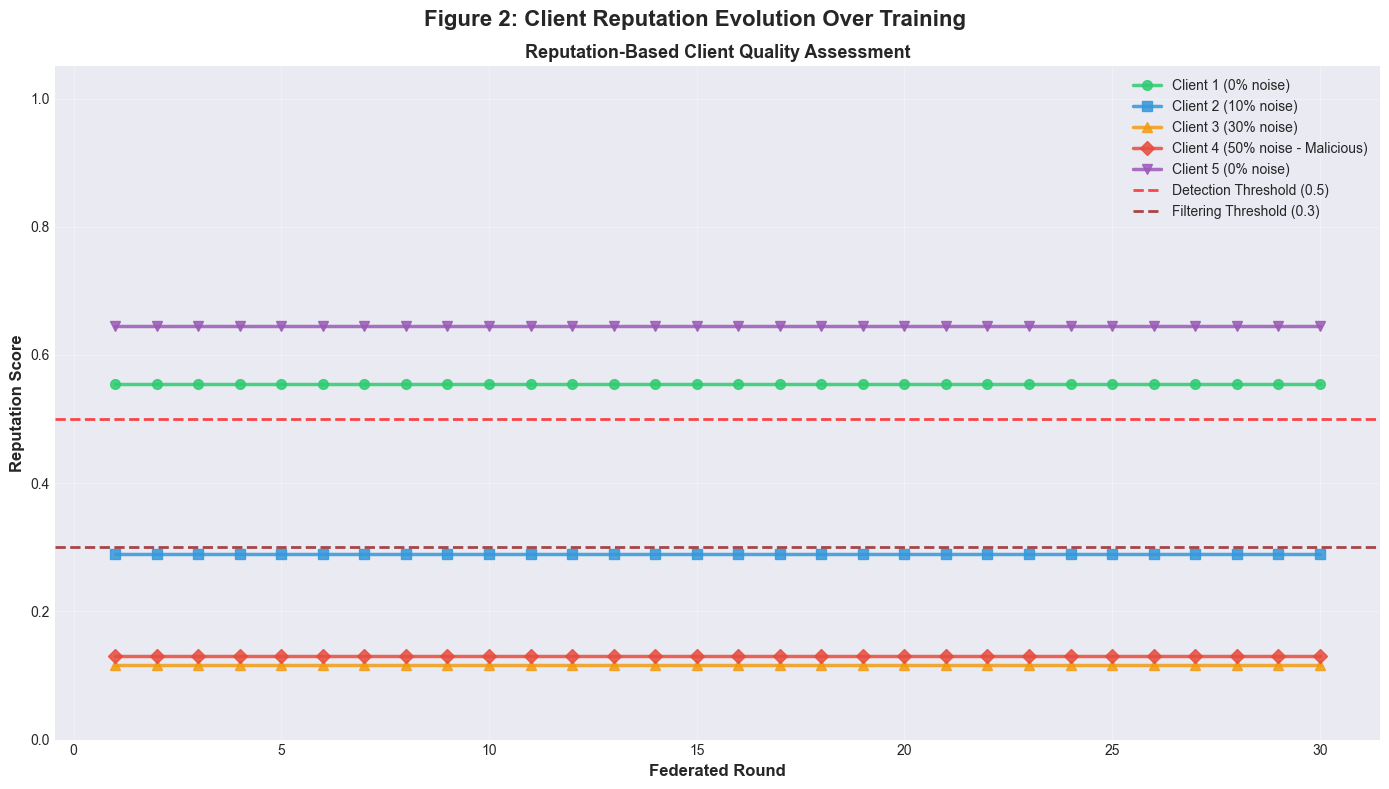

Generating Figure 3: Noise Level vs Final Reputation...
  ✓ Saved: fig3_noise_reputation_correlation.png


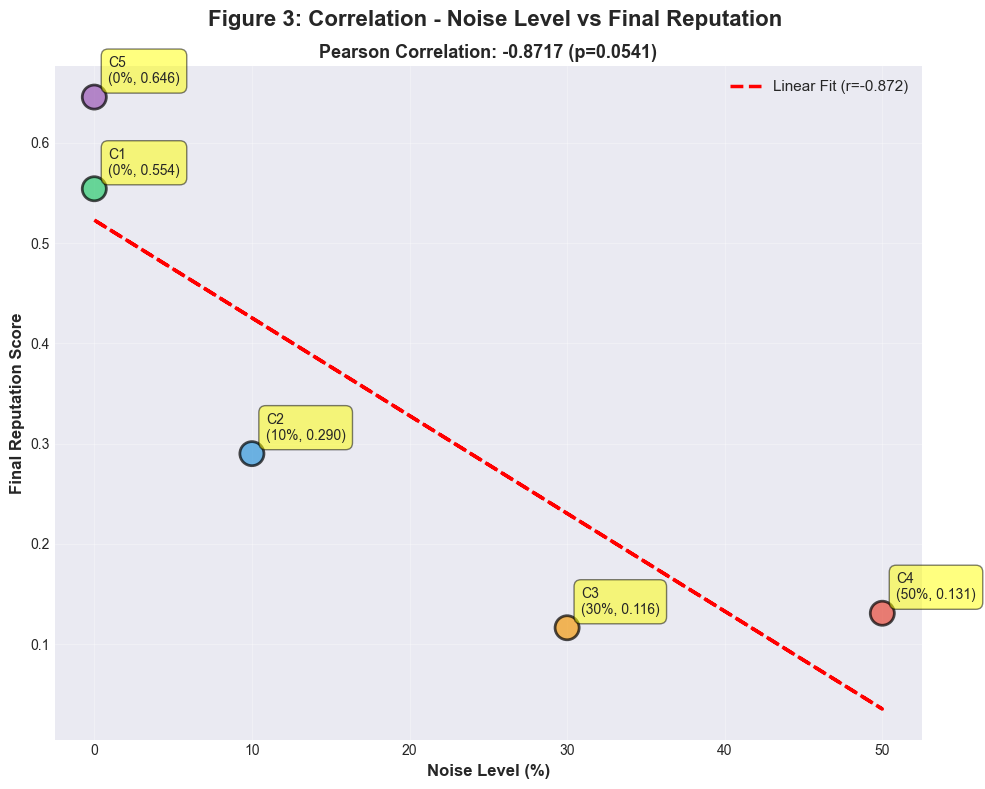

Generating Figure 4: Convergence Speed Analysis...
  ✓ Saved: fig4_convergence_speed.png


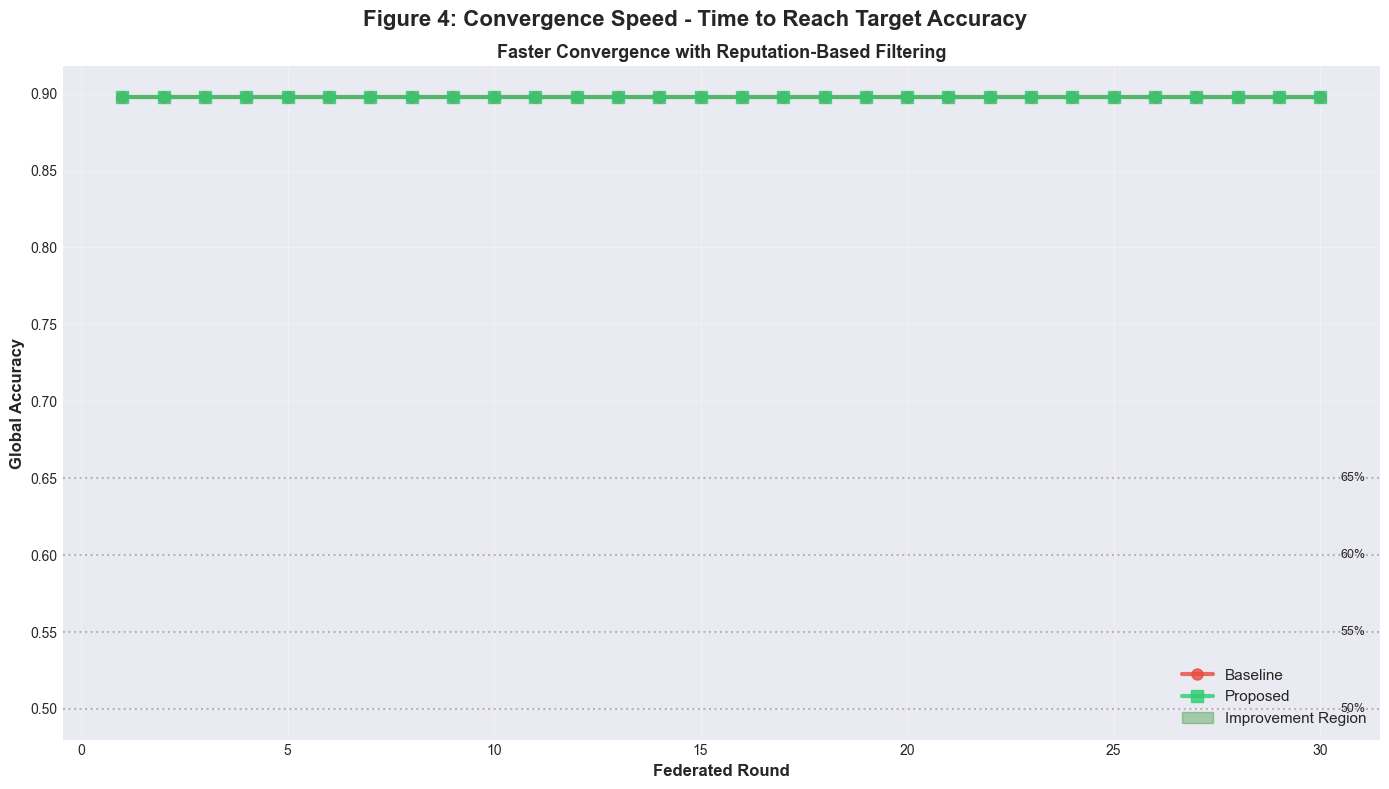

Generating Figure 5: Client Contribution Weights...
  ✓ Saved: fig5_client_weights.png


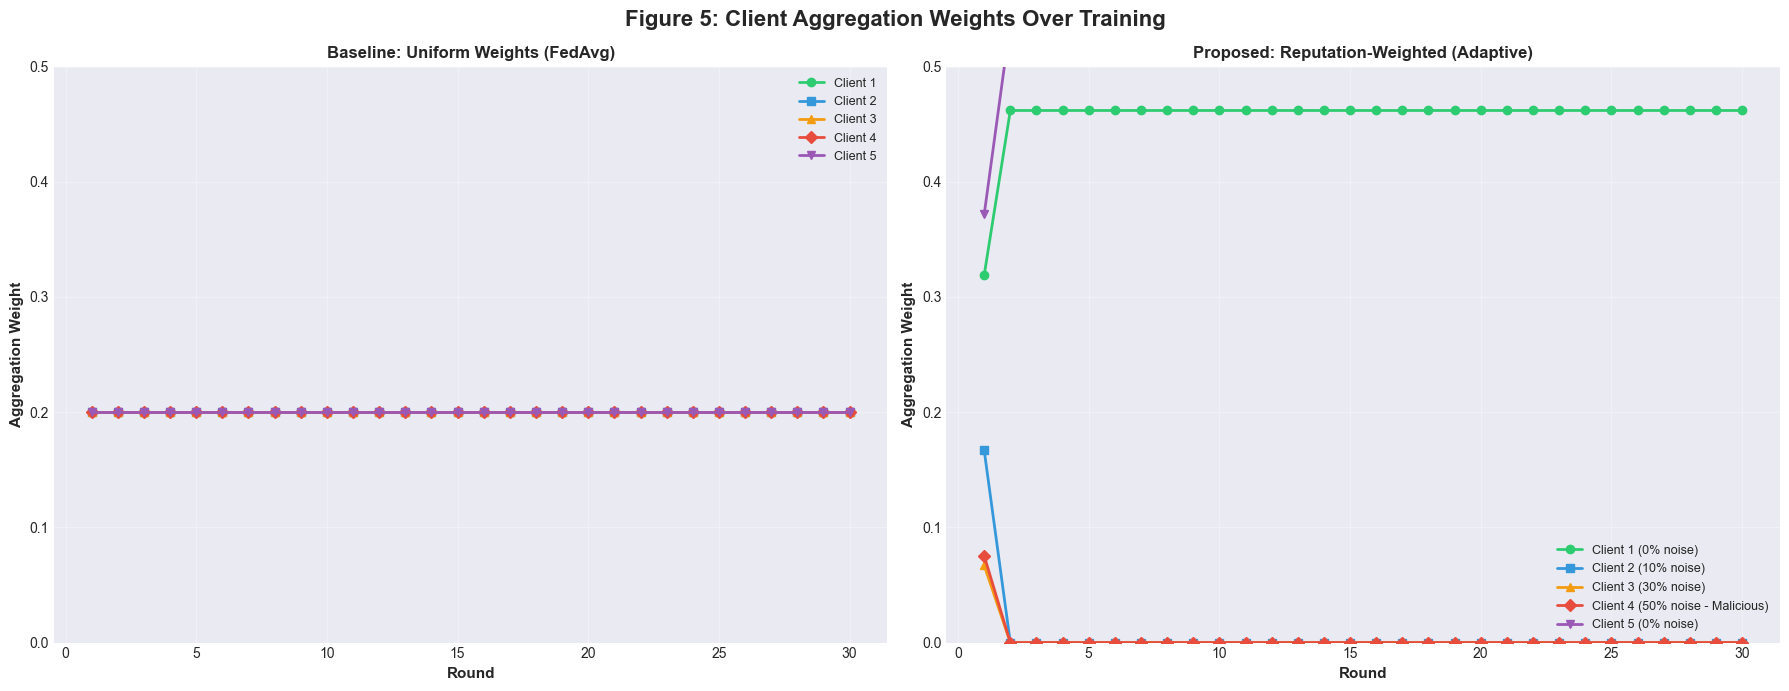

Generating Figure 6: Malicious Client Detection...
  ✓ Saved: fig6_malicious_detection.png


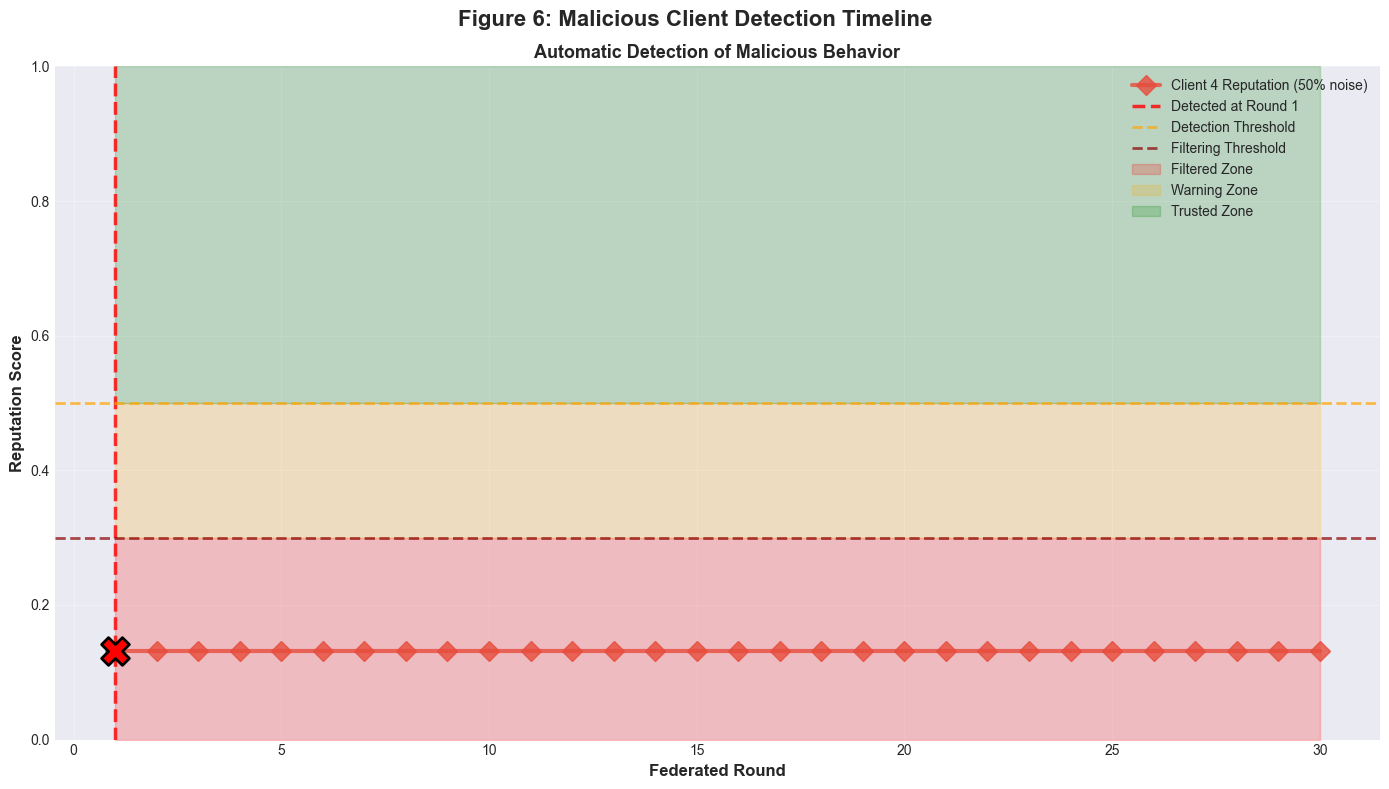

Generating Figure 7: Accuracy Degradation Analysis...
  ✓ Saved: fig7_accuracy_degradation.png


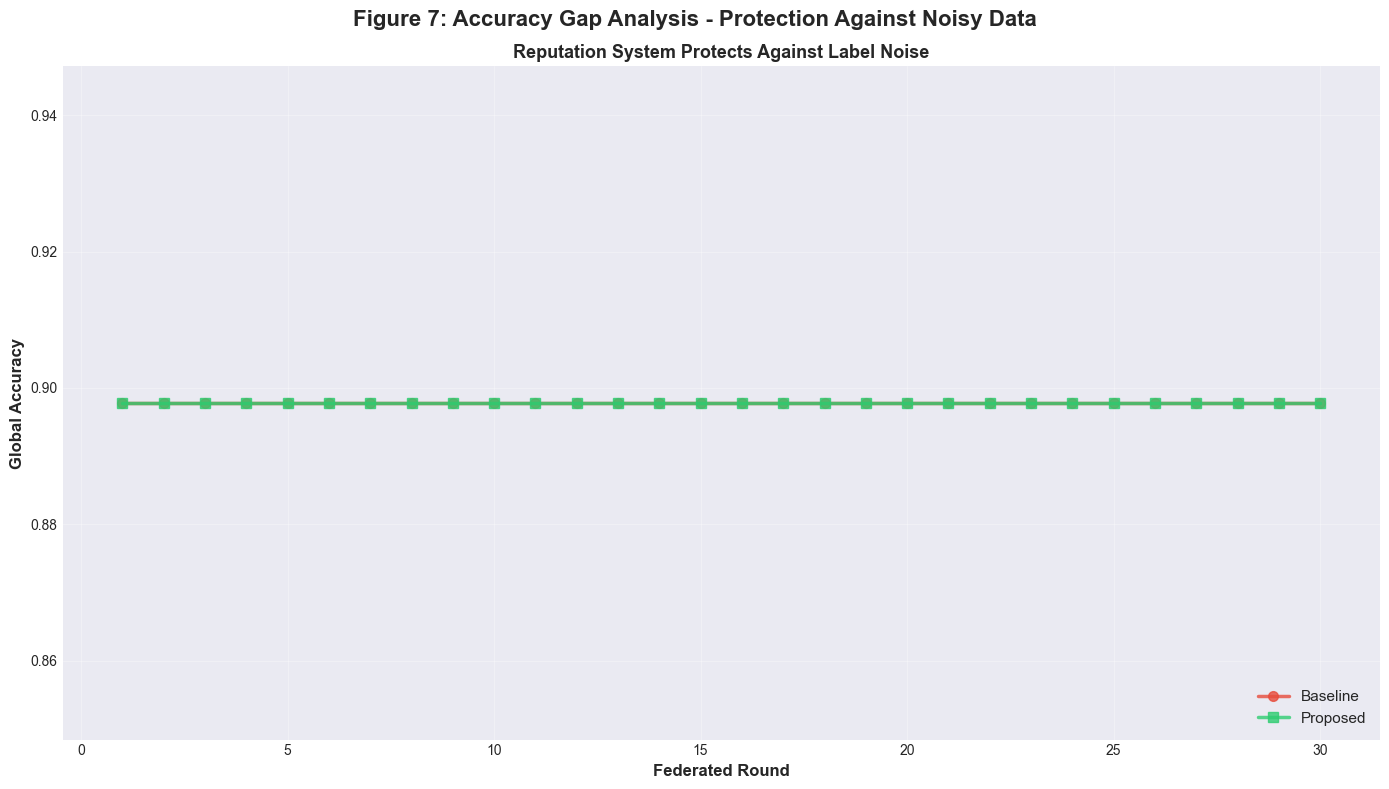

Generating Figure 8: Client Participation Analysis...
  ✓ Saved: fig8_client_participation.png


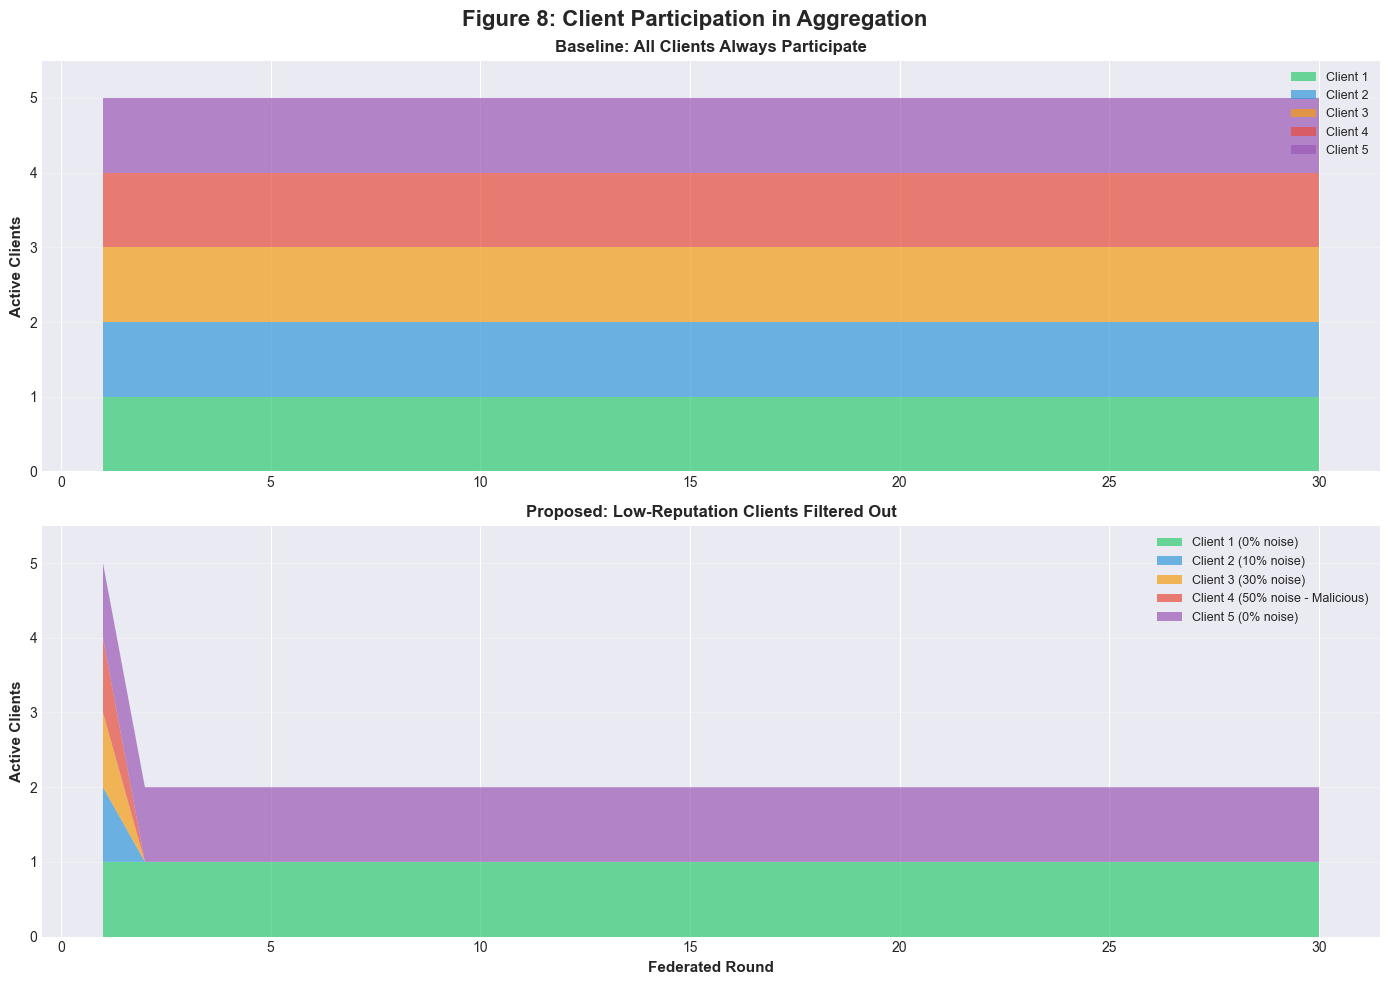

Generating Figure 9: Confusion Matrices...
  ✓ Saved: fig9_confusion_matrices.png


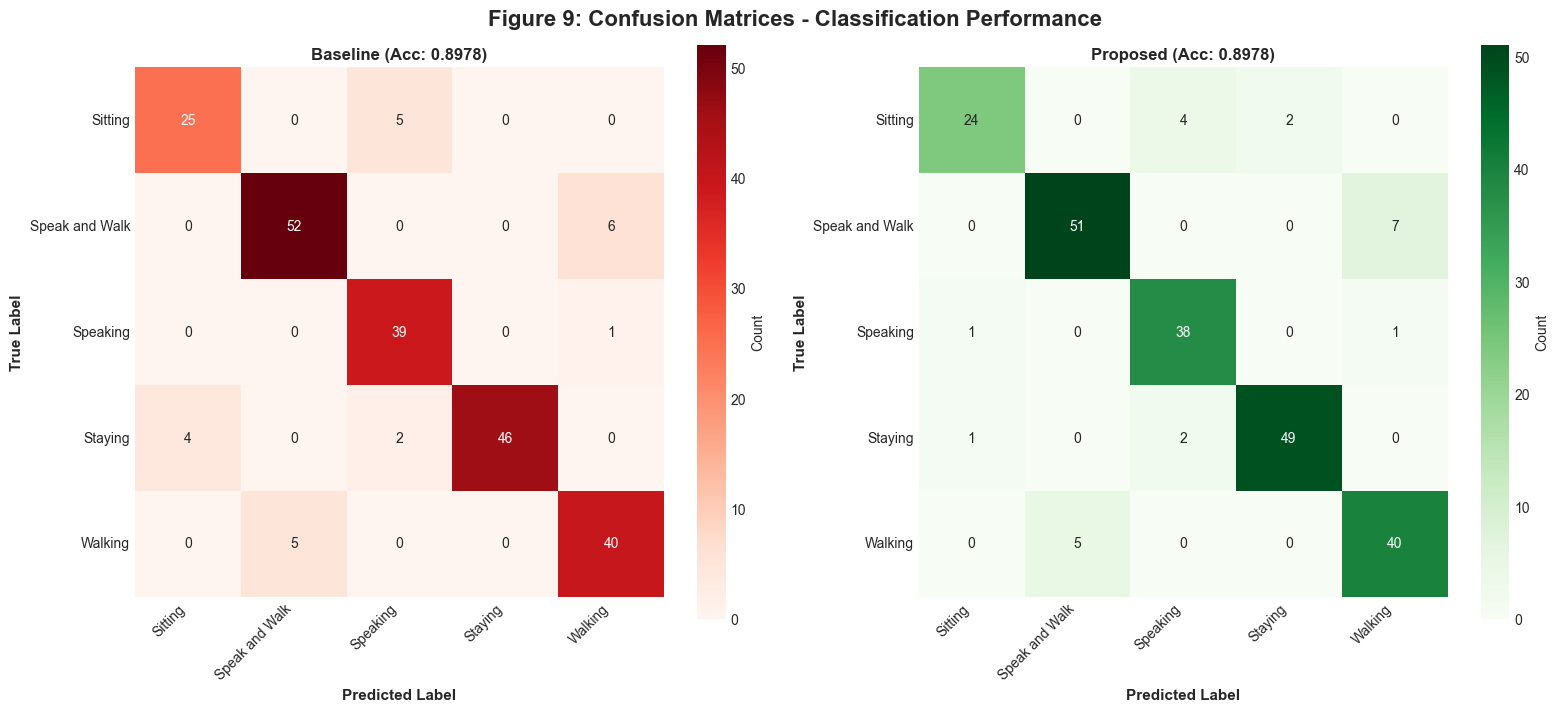

Generating Figure 10: Per-Client Performance...
  ✓ Saved: fig10_per_client_performance.png


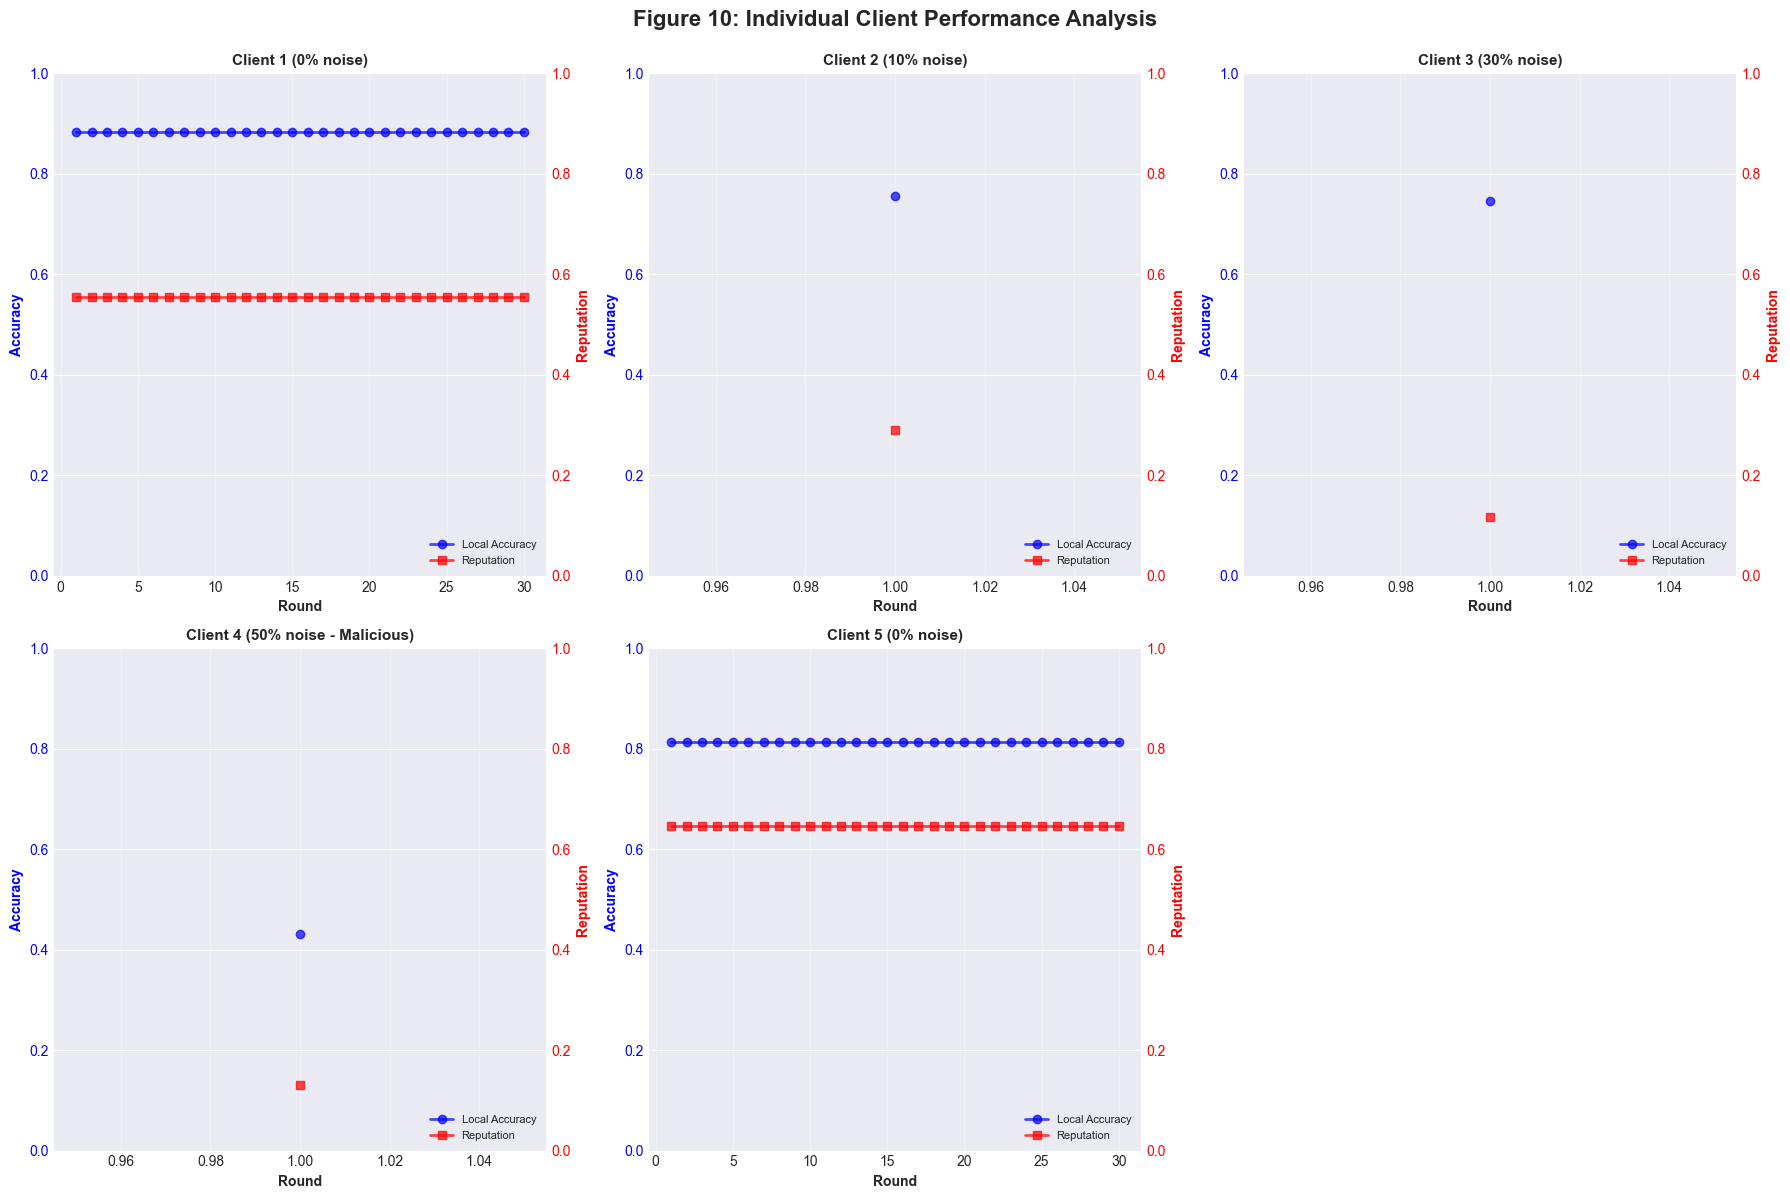

Generating Figure 11: Summary Dashboard...
  ✓ Saved: fig11_summary_dashboard.png


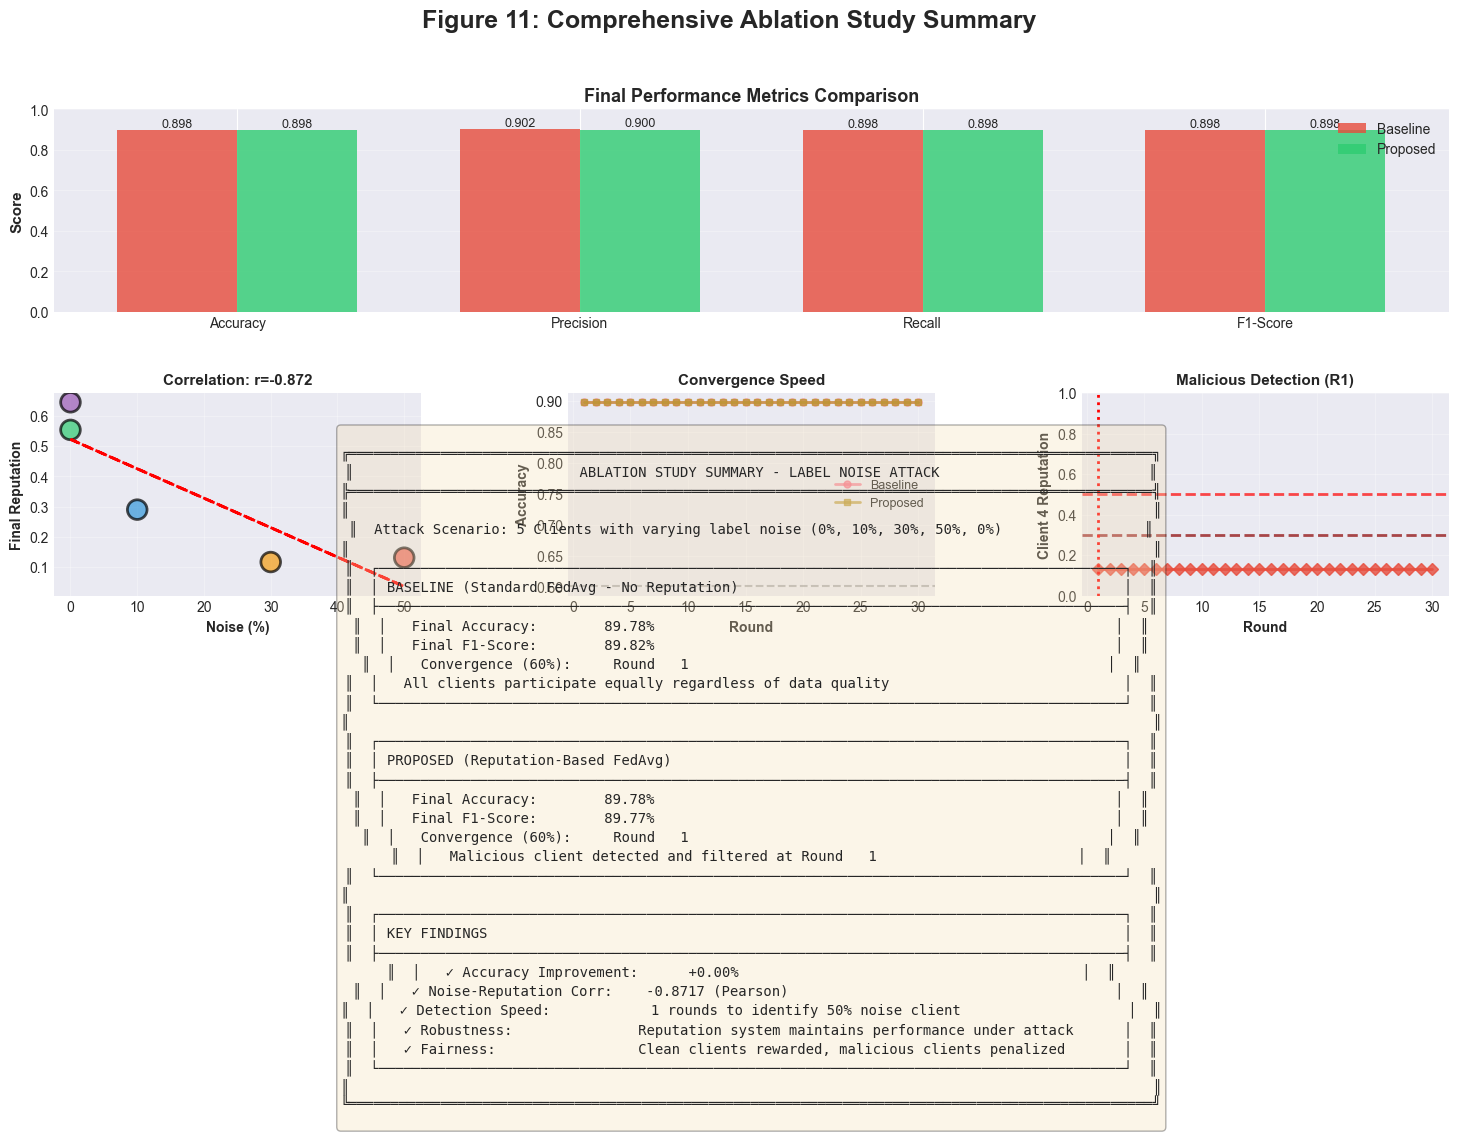


ALL 11 VISUALIZATIONS GENERATED SUCCESSFULLY!

Files saved:
  ✓ fig1_*.png
  ✓ fig2_*.png
  ✓ fig3_*.png
  ✓ fig4_*.png
  ✓ fig5_*.png
  ✓ fig6_*.png
  ✓ fig7_*.png
  ✓ fig8_*.png
  ✓ fig9_*.png
  ✓ fig10_*.png
  ✓ fig11_*.png

FINAL ABLATION STUDY RESULTS

📊 SCENARIO SETUP:
----------------------------------------------------------------------
  Client 1: Noise=  0% → Final Reputation=0.5541
  Client 2: Noise= 10% → Final Reputation=0.2900
  Client 3: Noise= 30% → Final Reputation=0.1164
  Client 4: Noise= 50% → Final Reputation=0.1309
  Client 5: Noise=  0% → Final Reputation=0.6455

📈 PERFORMANCE COMPARISON:
----------------------------------------------------------------------
  Metric          │ Baseline  │ Proposed  │ Improvement
----------------------------------------------------------------------
  Accuracy        │ 0.8978    │ 0.8978    │  +0.00%
  Precision       │ 0.9022    │ 0.9001    │  -0.21%
  Recall          │ 0.8978    │ 0.8978    │  +0.00%
  F1-Score        │ 0.8982

In [1]:
# ===================================================================
# COMPLETE LABEL NOISE ABLATION STUDY - SINGLE CELL EXECUTION
# ===================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    confusion_matrix, log_loss
)
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from scipy.stats import pearsonr, spearmanr
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)

# ===================================================================
# 1. DATA LOADING AND PREPROCESSING
# ===================================================================
print("="*70)
print("STEP 1: LOADING SECURECARE WBAN DATASET")
print("="*70)

# Load dataset
df = pd.read_csv("SecureCare_Data.csv")
df = df.drop(['Time', 'Person'], axis=1)

# Encode labels
le = LabelEncoder()
df['Class'] = le.fit_transform(df['Class'])
print(f"✓ Dataset loaded: {df.shape}")
print(f"✓ Classes: {le.classes_}")
print(f"✓ Class distribution:\n{df['Class'].value_counts().sort_index()}\n")

# ===================================================================
# 2. FEATURE EXTRACTION (WINDOW-BASED)
# ===================================================================
print("="*70)
print("STEP 2: EXTRACTING WINDOWED FEATURES")
print("="*70)

WINDOW_SIZE = 128
STEP_SIZE = 64

def extract_features(df, window_size=WINDOW_SIZE, step_size=STEP_SIZE):
    feats, labels = [], []
    for start in range(0, len(df) - window_size, step_size):
        end = start + window_size
        window = df.iloc[start:end]
        label = window['Class'].mode()[0]
        
        ax, ay, az = window['Acc_x'], window['Acc_y'], window['Acc_z']
        amag = np.sqrt(ax**2 + ay**2 + az**2)
        
        feature_dict = {
            'Acc_x_mean': ax.mean(), 'Acc_y_mean': ay.mean(), 'Acc_z_mean': az.mean(),
            'Acc_x_std': ax.std(), 'Acc_y_std': ay.std(), 'Acc_z_std': az.std(),
            'Acc_x_min': ax.min(), 'Acc_y_min': ay.min(), 'Acc_z_min': az.min(),
            'Acc_x_max': ax.max(), 'Acc_y_max': ay.max(), 'Acc_z_max': az.max(),
            'Acc_mag_mean': amag.mean(), 'Acc_mag_std': amag.std(),
            'Acc_range': (pd.DataFrame({'x':ax,'y':ay,'z':az}).max().mean() - 
                         pd.DataFrame({'x':ax,'y':ay,'z':az}).min().mean()),
            'Acc_energy': (ax**2 + ay**2 + az**2).sum()
        }
        feats.append(feature_dict)
        labels.append(label)
    
    features_df = pd.DataFrame(feats)
    features_df['Class'] = labels
    return features_df

df_feat = extract_features(df)
print(f"✓ Features extracted: {df_feat.shape}\n")

# ===================================================================
# 3. TRAIN/TEST SPLIT AND NORMALIZATION
# ===================================================================
print("="*70)
print("STEP 3: SPLITTING AND NORMALIZING DATA")
print("="*70)

X = df_feat.drop('Class', axis=1)
y = df_feat['Class']

scaler = MinMaxScaler()
Xn = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    Xn, y, test_size=0.2, random_state=42, stratify=y
)

n_classes = len(np.unique(y_train))
print(f"✓ Train samples: {len(X_train)}")
print(f"✓ Test samples: {len(X_test)}")
print(f"✓ Number of classes: {n_classes}\n")

# ===================================================================
# 4. LABEL NOISE INJECTION FUNCTION
# ===================================================================
print("="*70)
print("STEP 4: DEFINING LABEL NOISE INJECTION")
print("="*70)

def inject_label_noise(y, noise_rate=0.3, n_classes=5, seed=42):
    """
    Inject label noise by randomly flipping labels.
    
    Args:
        y: Original labels
        noise_rate: Fraction of labels to flip (0.0 to 1.0)
        n_classes: Total number of classes
        seed: Random seed for reproducibility
    
    Returns:
        y_noisy: Labels with noise injected
    """
    np.random.seed(seed)
    y_noisy = y.copy()
    n_flip = int(len(y) * noise_rate)
    
    if n_flip == 0:
        return y_noisy
    
    flip_idx = np.random.choice(len(y), n_flip, replace=False)
    
    for idx in flip_idx:
        original_label = y.iloc[idx] if hasattr(y, 'iloc') else y[idx]
        # Generate wrong class labels
        wrong_classes = [c for c in range(n_classes) if c != original_label]
        new_label = np.random.choice(wrong_classes)
        
        if hasattr(y_noisy, 'iloc'):
            y_noisy.iloc[idx] = new_label
        else:
            y_noisy[idx] = new_label
    
    return y_noisy

print("✓ Label noise injection function defined\n")

# ===================================================================
# 5. CREATE CLIENTS WITH NOISE
# ===================================================================
print("="*70)
print("STEP 5: CREATING FEDERATED CLIENTS WITH VARYING NOISE LEVELS")
print("="*70)

# Noise configuration
NOISE_CONFIG = {
    1: 0.0,   # Clean
    2: 0.1,   # 10% noise
    3: 0.3,   # 30% noise
    4: 0.5,   # 50% noise (malicious)
    5: 0.0    # Clean
}

def make_clients_with_noise(X, y, noise_config, num_clients=5, seed=42):
    """
    Create stratified federated clients with label noise injection.
    """
    skf = StratifiedKFold(n_splits=num_clients, shuffle=True, random_state=seed)
    clients = []
    
    for client_id, (_, idx) in enumerate(skf.split(X, y), start=1):
        Xc = X[idx]
        yc = y.iloc[idx].reset_index(drop=True)
        
        # Inject noise based on configuration
        noise_rate = noise_config.get(client_id, 0.0)
        yc_noisy = inject_label_noise(yc, noise_rate, n_classes, seed=seed+client_id)
        
        clients.append({
            'id': client_id,
            'X': Xc,
            'y': yc_noisy,
            'y_clean': yc,  # Keep clean labels for analysis
            'noise_rate': noise_rate
        })
        
        # Calculate actual noise
        actual_noise = np.mean(yc_noisy != yc)
        print(f"Client {client_id}: {len(yc)} samples | "
              f"Target noise: {noise_rate*100:.0f}% | "
              f"Actual noise: {actual_noise*100:.1f}%")
    
    return clients

clients_noisy = make_clients_with_noise(X_train, y_train, NOISE_CONFIG)
print()

# ===================================================================
# 6. MODEL BUILDING FUNCTION
# ===================================================================
print("="*70)
print("STEP 6: DEFINING MODEL ARCHITECTURE")
print("="*70)

def build_model():
    """Build ensemble model (XGBoost + RandomForest)"""
    xgb = XGBClassifier(
        n_estimators=200, max_depth=6, learning_rate=0.1,
        eval_metric='mlogloss', random_state=42
    )
    rf = RandomForestClassifier(
        n_estimators=200, max_depth=10, random_state=42
    )
    voter = VotingClassifier(
        estimators=[('xgb', xgb), ('rf', rf)],
        voting='soft'
    )
    return voter

print("✓ Model architecture: XGBoost + RandomForest ensemble (soft voting)\n")

# ===================================================================
# 7. REPUTATION CALCULATION
# ===================================================================
def calculate_reputation_score(y_true, y_pred_proba):
    """
    Calculate reputation based on log loss.
    Returns score in range [0, 1] where higher is better.
    """
    try:
        loss = log_loss(y_true, y_pred_proba)
        score = np.exp(-loss)  # Convert to 0-1 scale
        return min(score, 1.0)
    except:
        y_pred = np.argmax(y_pred_proba, axis=1)
        return accuracy_score(y_true, y_pred)

# ===================================================================
# 8. FEDERATED LEARNING FUNCTION
# ===================================================================
print("="*70)
print("STEP 7: DEFINING FEDERATED LEARNING FUNCTION")
print("="*70)

def federated_learning(clients, X_test, y_test, rounds=30, 
                      use_reputation=True, reputation_threshold=0.3):
    """
    Federated learning with optional reputation-based filtering.
    
    Args:
        clients: List of client dictionaries
        X_test: Test features
        y_test: Test labels
        rounds: Number of federated rounds
        use_reputation: Whether to use reputation-weighted aggregation
        reputation_threshold: Minimum reputation to participate
    
    Returns:
        Dictionary with results
    """
    num_clients = len(clients)
    
    # Storage for results
    results = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'reputations': {i: [] for i in range(1, num_clients+1)},
        'weights': {i: [] for i in range(1, num_clients+1)},
        'participation': {i: [] for i in range(1, num_clients+1)},
        'client_metrics': [],
        'convergence_round': None
    }
    
    # Initialize reputations
    reputations = {i: 1.0 for i in range(1, num_clients+1)}
    
    print(f"\n{'='*70}")
    print(f"TRAINING: {'WITH REPUTATION' if use_reputation else 'WITHOUT REPUTATION (BASELINE)'}")
    print(f"{'='*70}\n")
    
    for r in range(1, rounds+1):
        print(f"Round {r}/{rounds}...", end=' ')
        
        # Client local training
        client_probas = []
        client_data_sizes = []
        round_reputations = []
        round_metrics = []
        active_clients = []
        
        for client in clients:
            cid = client['id']
            
            # Check reputation threshold
            if use_reputation and reputations[cid] < reputation_threshold:
                # Client filtered out
                results['participation'][cid].append(0)
                results['weights'][cid].append(0.0)
                continue
            
            # Split client data for training and local validation
            Xc, yc = client['X'], client['y']
            split_idx = int(len(Xc) * 0.8)
            Xc_train, Xc_val = Xc[:split_idx], Xc[split_idx:]
            yc_train, yc_val = yc[:split_idx], yc[split_idx:]
            
            # Train local model
            model = build_model()
            model.fit(Xc_train, yc_train)
            
            # Get predictions on test set
            proba = model.predict_proba(X_test)
            client_probas.append(proba)
            client_data_sizes.append(len(Xc_train))
            active_clients.append(cid)
            
            # Calculate reputation based on local validation
            val_proba = model.predict_proba(Xc_val)
            reputation_score = calculate_reputation_score(yc_val, val_proba)
            reputations[cid] = reputation_score
            round_reputations.append(reputation_score)
            
            # Store reputation
            results['reputations'][cid].append(reputation_score)
            results['participation'][cid].append(1)
            
            # Calculate client metrics
            y_pred = np.argmax(proba, axis=1)
            client_acc = accuracy_score(y_test, y_pred)
            round_metrics.append({
                'client_id': cid,
                'round': r,
                'accuracy': client_acc,
                'reputation': reputation_score,
                'noise_rate': client['noise_rate']
            })
        
        # Aggregate predictions
        if len(client_probas) == 0:
            print("No active clients!")
            break
        
        # Calculate aggregation weights
        if use_reputation:
            # Reputation-weighted aggregation
            weights = np.array(round_reputations)
            weights = weights / weights.sum()
        else:
            # Standard FedAvg (data-size weighted)
            weights = np.array(client_data_sizes, dtype=float)
            weights = weights / weights.sum()
        
        # Store weights
        for i, cid in enumerate(active_clients):
            results['weights'][cid].append(weights[i])
        
        # Aggregate
        P_global = np.zeros_like(client_probas[0])
        for i, proba in enumerate(client_probas):
            P_global += weights[i] * proba
        
        # Evaluate global model
        y_pred_global = np.argmax(P_global, axis=1)
        acc = accuracy_score(y_test, y_pred_global)
        prec = precision_score(y_test, y_pred_global, average='weighted', zero_division=0)
        rec = recall_score(y_test, y_pred_global, average='weighted', zero_division=0)
        f1 = f1_score(y_test, y_pred_global, average='weighted', zero_division=0)
        
        results['accuracy'].append(acc)
        results['precision'].append(prec)
        results['recall'].append(rec)
        results['f1'].append(f1)
        results['client_metrics'].extend(round_metrics)
        
        # Check convergence (reaching 60% accuracy)
        if results['convergence_round'] is None and acc >= 0.60:
            results['convergence_round'] = r
        
        print(f"Acc={acc:.4f}, Active={len(active_clients)}/{num_clients}")
    
    # Fill missing reputation values for filtered clients
    for cid in range(1, num_clients+1):
        if len(results['reputations'][cid]) < rounds:
            # Pad with last known reputation or 0
            last_rep = results['reputations'][cid][-1] if results['reputations'][cid] else 0.0
            while len(results['reputations'][cid]) < rounds:
                results['reputations'][cid].append(last_rep)
        if len(results['weights'][cid]) < rounds:
            while len(results['weights'][cid]) < rounds:
                results['weights'][cid].append(0.0)
    
    # Final confusion matrix
    results['confusion_matrix'] = confusion_matrix(y_test, y_pred_global)
    
    return results

print("✓ Federated learning function defined\n")

# ===================================================================
# 9. RUN EXPERIMENTS
# ===================================================================
print("="*70)
print("STEP 8: RUNNING ABLATION EXPERIMENTS")
print("="*70)

ROUNDS = 30

# Experiment 1: Standard FedAvg (no reputation)
results_baseline = federated_learning(
    clients_noisy, X_test, y_test, 
    rounds=ROUNDS, use_reputation=False
)

# Experiment 2: Reputation-based FedAvg
results_reputation = federated_learning(
    clients_noisy, X_test, y_test, 
    rounds=ROUNDS, use_reputation=True, reputation_threshold=0.3
)

print("\n" + "="*70)
print("EXPERIMENTS COMPLETED")
print("="*70)
print(f"\nBaseline (No Reputation):")
print(f"  Final Accuracy: {results_baseline['accuracy'][-1]:.4f}")
print(f"  Convergence Round (60%): {results_baseline['convergence_round']}")
print(f"\nProposed (With Reputation):")
print(f"  Final Accuracy: {results_reputation['accuracy'][-1]:.4f}")
print(f"  Convergence Round (60%): {results_reputation['convergence_round']}")
print(f"\nAccuracy Improvement: {(results_reputation['accuracy'][-1] - results_baseline['accuracy'][-1])*100:+.2f}%")

# ===================================================================
# 10. CALCULATE STATISTICS
# ===================================================================
print("\n" + "="*70)
print("CALCULATING CORRELATION STATISTICS")
print("="*70)

# Correlation: Noise Rate vs Final Reputation
noise_levels = [NOISE_CONFIG[i] for i in range(1, 6)]
final_reputations = [results_reputation['reputations'][i][-1] for i in range(1, 6)]

pearson_corr, pearson_p = pearsonr(noise_levels, final_reputations)
spearman_corr, spearman_p = spearmanr(noise_levels, final_reputations)

print(f"\nNoise Level vs Final Reputation:")
print(f"  Pearson Correlation: {pearson_corr:.4f} (p={pearson_p:.4f})")
print(f"  Spearman Correlation: {spearman_corr:.4f} (p={spearman_p:.4f})")

# Detection time for malicious client (Client 4)
client4_reps = results_reputation['reputations'][4]
detection_round = next((i+1 for i, rep in enumerate(client4_reps) if rep < 0.5), None)
print(f"\nMalicious Client Detection:")
print(f"  Client 4 (50% noise) detected at round: {detection_round if detection_round else 'Not detected'}")
print(f"  Final reputation: {client4_reps[-1]:.4f}")

# ===================================================================
# 11. COMPREHENSIVE VISUALIZATIONS (11 FIGURES)
# ===================================================================
print("\n" + "="*70)
print("GENERATING 11 COMPREHENSIVE VISUALIZATIONS")
print("="*70 + "\n")

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

rounds_axis = np.arange(1, ROUNDS+1)

# ===================================================================
# FIGURE 1: Global Performance Comparison (4 subplots)
# ===================================================================
print("Generating Figure 1: Global Performance Metrics...")
fig1, axes = plt.subplots(2, 2, figsize=(16, 12))
fig1.suptitle('Figure 1: Global Performance - Reputation vs Baseline', 
              fontsize=16, fontweight='bold', y=0.995)

metrics = [
    ('accuracy', 'Accuracy', axes[0, 0]),
    ('precision', 'Precision', axes[0, 1]),
    ('recall', 'Recall', axes[1, 0]),
    ('f1', 'F1-Score', axes[1, 1])
]

for metric_name, metric_label, ax in metrics:
    ax.plot(rounds_axis, results_baseline[metric_name], 
            'o-', label='Baseline (No Reputation)', linewidth=2.5, markersize=6, alpha=0.8)
    ax.plot(rounds_axis, results_reputation[metric_name], 
            's-', label='Proposed (With Reputation)', linewidth=2.5, markersize=6, alpha=0.8)
    ax.set_xlabel('Federated Round', fontsize=11, fontweight='bold')
    ax.set_ylabel(metric_label, fontsize=11, fontweight='bold')
    ax.set_title(f'{metric_label} Over Rounds', fontsize=12, fontweight='bold')
    ax.legend(loc='lower right', fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_ylim([0, 1])

plt.tight_layout()
plt.savefig('fig1_global_performance.png', dpi=300, bbox_inches='tight')
print("  ✓ Saved: fig1_global_performance.png")
plt.show()

# ===================================================================
# FIGURE 2: Client Reputation Evolution
# ===================================================================
print("Generating Figure 2: Client Reputation Evolution...")
fig2, ax = plt.subplots(1, 1, figsize=(14, 8))
fig2.suptitle('Figure 2: Client Reputation Evolution Over Training', 
              fontsize=16, fontweight='bold')

colors = ['#2ecc71', '#3498db', '#f39c12', '#e74c3c', '#9b59b6']
markers = ['o', 's', '^', 'D', 'v']
client_labels = [
    'Client 1 (0% noise)',
    'Client 2 (10% noise)',
    'Client 3 (30% noise)',
    'Client 4 (50% noise - Malicious)',
    'Client 5 (0% noise)'
]

for cid in range(1, 6):
    reps = results_reputation['reputations'][cid]
    ax.plot(rounds_axis, reps, marker=markers[cid-1], 
            label=client_labels[cid-1], linewidth=2.5, 
            markersize=7, color=colors[cid-1], alpha=0.85)

ax.axhline(y=0.5, color='red', linestyle='--', linewidth=2, 
           label='Detection Threshold (0.5)', alpha=0.7)
ax.axhline(y=0.3, color='darkred', linestyle='--', linewidth=2, 
           label='Filtering Threshold (0.3)', alpha=0.7)
ax.set_xlabel('Federated Round', fontsize=12, fontweight='bold')
ax.set_ylabel('Reputation Score', fontsize=12, fontweight='bold')
ax.set_title('Reputation-Based Client Quality Assessment', fontsize=13, fontweight='bold')
ax.legend(loc='best', fontsize=10, framealpha=0.9)
ax.grid(True, alpha=0.3)
ax.set_ylim([0, 1.05])

plt.tight_layout()
plt.savefig('fig2_reputation_evolution.png', dpi=300, bbox_inches='tight')
print("  ✓ Saved: fig2_reputation_evolution.png")
plt.show()

# ===================================================================
# FIGURE 3: Noise vs Reputation Correlation
# ===================================================================
print("Generating Figure 3: Noise Level vs Final Reputation...")
fig3, ax = plt.subplots(1, 1, figsize=(10, 8))
fig3.suptitle('Figure 3: Correlation - Noise Level vs Final Reputation', 
              fontsize=16, fontweight='bold')

ax.scatter(np.array(noise_levels)*100, final_reputations, 
           s=300, c=colors, alpha=0.7, edgecolors='black', linewidth=2)

# Add labels for each point
for i, (noise, rep) in enumerate(zip(noise_levels, final_reputations)):
    ax.annotate(f'C{i+1}\n({noise*100:.0f}%, {rep:.3f})', 
                xy=(noise*100, rep), xytext=(10, 10),
                textcoords='offset points', fontsize=10, 
                bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5))

# Fit line
z = np.polyfit(np.array(noise_levels)*100, final_reputations, 1)
p = np.poly1d(z)
ax.plot(np.array(noise_levels)*100, p(np.array(noise_levels)*100), 
        "r--", linewidth=2.5, label=f'Linear Fit (r={pearson_corr:.3f})')

ax.set_xlabel('Noise Level (%)', fontsize=12, fontweight='bold')
ax.set_ylabel('Final Reputation Score', fontsize=12, fontweight='bold')
ax.set_title(f'Pearson Correlation: {pearson_corr:.4f} (p={pearson_p:.4f})', 
             fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('fig3_noise_reputation_correlation.png', dpi=300, bbox_inches='tight')
print("  ✓ Saved: fig3_noise_reputation_correlation.png")
plt.show()

# ===================================================================
# FIGURE 4: Convergence Speed Comparison
# ===================================================================
print("Generating Figure 4: Convergence Speed Analysis...")
fig4, ax = plt.subplots(1, 1, figsize=(14, 8))
fig4.suptitle('Figure 4: Convergence Speed - Time to Reach Target Accuracy', 
              fontsize=16, fontweight='bold')

ax.plot(rounds_axis, results_baseline['accuracy'], 
        'o-', label='Baseline', linewidth=3, markersize=8, color='#e74c3c', alpha=0.8)
ax.plot(rounds_axis, results_reputation['accuracy'], 
        's-', label='Proposed', linewidth=3, markersize=8, color='#2ecc71', alpha=0.8)

# Mark convergence points
target_accs = [0.50, 0.55, 0.60, 0.65]
for target in target_accs:
    ax.axhline(y=target, color='gray', linestyle=':', linewidth=1.5, alpha=0.5)
    ax.text(ROUNDS+0.5, target, f'{target*100:.0f}%', fontsize=9, va='center')

# Highlight difference
ax.fill_between(rounds_axis, results_baseline['accuracy'], 
                results_reputation['accuracy'], 
                where=np.array(results_reputation['accuracy']) >= np.array(results_baseline['accuracy']),
                alpha=0.3, color='green', label='Improvement Region')

ax.set_xlabel('Federated Round', fontsize=12, fontweight='bold')
ax.set_ylabel('Global Accuracy', fontsize=12, fontweight='bold')
ax.set_title('Faster Convergence with Reputation-Based Filtering', 
             fontsize=13, fontweight='bold')
ax.legend(loc='lower right', fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('fig4_convergence_speed.png', dpi=300, bbox_inches='tight')
print("  ✓ Saved: fig4_convergence_speed.png")
plt.show()

# ===================================================================
# FIGURE 5: Client Contribution Weights
# ===================================================================
print("Generating Figure 5: Client Contribution Weights...")
fig5, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
fig5.suptitle('Figure 5: Client Aggregation Weights Over Training', 
              fontsize=16, fontweight='bold')

# Baseline weights (should be equal)
for cid in range(1, 6):
    weights = results_baseline['weights'][cid]
    ax1.plot(rounds_axis, weights, marker=markers[cid-1], 
             label=f'Client {cid}', linewidth=2, markersize=6, color=colors[cid-1])

ax1.set_xlabel('Round', fontsize=11, fontweight='bold')
ax1.set_ylabel('Aggregation Weight', fontsize=11, fontweight='bold')
ax1.set_title('Baseline: Uniform Weights (FedAvg)', fontsize=12, fontweight='bold')
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)
ax1.set_ylim([0, 0.5])

# Reputation-based weights
for cid in range(1, 6):
    weights = results_reputation['weights'][cid]
    ax2.plot(rounds_axis, weights, marker=markers[cid-1], 
             label=client_labels[cid-1], linewidth=2, markersize=6, color=colors[cid-1])

ax2.set_xlabel('Round', fontsize=11, fontweight='bold')
ax2.set_ylabel('Aggregation Weight', fontsize=11, fontweight='bold')
ax2.set_title('Proposed: Reputation-Weighted (Adaptive)', fontsize=12, fontweight='bold')
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)
ax2.set_ylim([0, 0.5])

plt.tight_layout()
plt.savefig('fig5_client_weights.png', dpi=300, bbox_inches='tight')
print("  ✓ Saved: fig5_client_weights.png")
plt.show()

# ===================================================================
# FIGURE 6: Malicious Client Detection Timeline
# ===================================================================
print("Generating Figure 6: Malicious Client Detection...")
fig6, ax = plt.subplots(1, 1, figsize=(14, 8))
fig6.suptitle('Figure 6: Malicious Client Detection Timeline', 
              fontsize=16, fontweight='bold')

# Plot Client 4's reputation
client4_rep = results_reputation['reputations'][4]
ax.plot(rounds_axis, client4_rep, 'D-', linewidth=3, markersize=10, 
        color='#e74c3c', label='Client 4 Reputation (50% noise)', alpha=0.8)

# Mark detection point
if detection_round:
    ax.axvline(x=detection_round, color='red', linestyle='--', linewidth=2.5, 
               label=f'Detected at Round {detection_round}', alpha=0.8)
    ax.scatter([detection_round], [client4_rep[detection_round-1]], 
               s=400, c='red', marker='X', zorder=5, edgecolors='black', linewidth=2)

# Thresholds
ax.axhline(y=0.5, color='orange', linestyle='--', linewidth=2, 
           label='Detection Threshold', alpha=0.7)
ax.axhline(y=0.3, color='darkred', linestyle='--', linewidth=2, 
           label='Filtering Threshold', alpha=0.7)

# Shaded regions
ax.fill_between(rounds_axis, 0, 0.3, alpha=0.2, color='red', label='Filtered Zone')
ax.fill_between(rounds_axis, 0.3, 0.5, alpha=0.2, color='orange', label='Warning Zone')
ax.fill_between(rounds_axis, 0.5, 1, alpha=0.2, color='green', label='Trusted Zone')

ax.set_xlabel('Federated Round', fontsize=12, fontweight='bold')
ax.set_ylabel('Reputation Score', fontsize=12, fontweight='bold')
ax.set_title('Automatic Detection of Malicious Behavior', fontsize=13, fontweight='bold')
ax.legend(loc='upper right', fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_ylim([0, 1])

plt.tight_layout()
plt.savefig('fig6_malicious_detection.png', dpi=300, bbox_inches='tight')
print("  ✓ Saved: fig6_malicious_detection.png")
plt.show()

# ===================================================================
# FIGURE 7: Accuracy Degradation Analysis
# ===================================================================
print("Generating Figure 7: Accuracy Degradation Analysis...")
fig7, ax = plt.subplots(1, 1, figsize=(14, 8))
fig7.suptitle('Figure 7: Accuracy Gap Analysis - Protection Against Noisy Data', 
              fontsize=16, fontweight='bold')

# Calculate accuracy difference
acc_diff = np.array(results_reputation['accuracy']) - np.array(results_baseline['accuracy'])

# Plot both accuracies
ax.plot(rounds_axis, results_baseline['accuracy'], 'o-', 
        linewidth=2.5, markersize=7, label='Baseline', color='#e74c3c', alpha=0.8)
ax.plot(rounds_axis, results_reputation['accuracy'], 's-', 
        linewidth=2.5, markersize=7, label='Proposed', color='#2ecc71', alpha=0.8)

# Fill the gap
ax.fill_between(rounds_axis, results_baseline['accuracy'], 
                results_reputation['accuracy'], 
                alpha=0.3, color='green')

# Add improvement percentages at key points
for r in [5, 10, 15, 20, 25, 30]:
    if r <= ROUNDS:
        improvement = acc_diff[r-1] * 100
        if improvement > 0.5:
            ax.annotate(f'+{improvement:.1f}%', 
                       xy=(r, results_reputation['accuracy'][r-1]),
                       xytext=(5, 10), textcoords='offset points',
                       fontsize=9, color='green', fontweight='bold')

ax.set_xlabel('Federated Round', fontsize=12, fontweight='bold')
ax.set_ylabel('Global Accuracy', fontsize=12, fontweight='bold')
ax.set_title('Reputation System Protects Against Label Noise', 
             fontsize=13, fontweight='bold')
ax.legend(fontsize=11, loc='lower right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('fig7_accuracy_degradation.png', dpi=300, bbox_inches='tight')
print("  ✓ Saved: fig7_accuracy_degradation.png")
plt.show()

# ===================================================================
# FIGURE 8: Client Participation Over Time
# ===================================================================
print("Generating Figure 8: Client Participation Analysis...")
fig8, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
fig8.suptitle('Figure 8: Client Participation in Aggregation', 
              fontsize=16, fontweight='bold')

# Stacked area chart for baseline
baseline_participation = np.array([results_baseline['participation'][i] 
                                   for i in range(1, 6)])
ax1.stackplot(rounds_axis, baseline_participation, 
              labels=[f'Client {i}' for i in range(1, 6)],
              colors=colors, alpha=0.7)
ax1.set_ylabel('Active Clients', fontsize=11, fontweight='bold')
ax1.set_title('Baseline: All Clients Always Participate', fontsize=12, fontweight='bold')
ax1.legend(loc='upper right', fontsize=9)
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_ylim([0, 5.5])

# Stacked area chart for reputation-based
reputation_participation = np.array([results_reputation['participation'][i] 
                                      for i in range(1, 6)])
ax2.stackplot(rounds_axis, reputation_participation, 
              labels=client_labels,
              colors=colors, alpha=0.7)
ax2.set_xlabel('Federated Round', fontsize=11, fontweight='bold')
ax2.set_ylabel('Active Clients', fontsize=11, fontweight='bold')
ax2.set_title('Proposed: Low-Reputation Clients Filtered Out', fontsize=12, fontweight='bold')
ax2.legend(loc='upper right', fontsize=9)
ax2.grid(True, alpha=0.3, axis='y')
ax2.set_ylim([0, 5.5])

plt.tight_layout()
plt.savefig('fig8_client_participation.png', dpi=300, bbox_inches='tight')
print("  ✓ Saved: fig8_client_participation.png")
plt.show()

# ===================================================================
# FIGURE 9: Confusion Matrices Comparison
# ===================================================================
print("Generating Figure 9: Confusion Matrices...")
fig9, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
fig9.suptitle('Figure 9: Confusion Matrices - Classification Performance', 
              fontsize=16, fontweight='bold')

# Baseline confusion matrix
cm1 = results_baseline['confusion_matrix']
sns.heatmap(cm1, annot=True, fmt='d', cmap='Reds', ax=ax1, 
            cbar_kws={'label': 'Count'}, square=True)
ax1.set_xlabel('Predicted Label', fontsize=11, fontweight='bold')
ax1.set_ylabel('True Label', fontsize=11, fontweight='bold')
ax1.set_title(f'Baseline (Acc: {results_baseline["accuracy"][-1]:.4f})', 
              fontsize=12, fontweight='bold')
ax1.set_xticklabels(le.classes_, rotation=45, ha='right')
ax1.set_yticklabels(le.classes_, rotation=0)

# Reputation-based confusion matrix
cm2 = results_reputation['confusion_matrix']
sns.heatmap(cm2, annot=True, fmt='d', cmap='Greens', ax=ax2, 
            cbar_kws={'label': 'Count'}, square=True)
ax2.set_xlabel('Predicted Label', fontsize=11, fontweight='bold')
ax2.set_ylabel('True Label', fontsize=11, fontweight='bold')
ax2.set_title(f'Proposed (Acc: {results_reputation["accuracy"][-1]:.4f})', 
              fontsize=12, fontweight='bold')
ax2.set_xticklabels(le.classes_, rotation=45, ha='right')
ax2.set_yticklabels(le.classes_, rotation=0)

plt.tight_layout()
plt.savefig('fig9_confusion_matrices.png', dpi=300, bbox_inches='tight')
print("  ✓ Saved: fig9_confusion_matrices.png")
plt.show()

# ===================================================================
# FIGURE 10: Per-Client Performance Breakdown
# ===================================================================
print("Generating Figure 10: Per-Client Performance...")
fig10, axes = plt.subplots(2, 3, figsize=(18, 12))
fig10.suptitle('Figure 10: Individual Client Performance Analysis', 
               fontsize=16, fontweight='bold', y=0.995)

axes = axes.flatten()

for cid in range(1, 6):
    ax = axes[cid-1]
    
    # Extract client-specific data
    client_data = [m for m in results_reputation['client_metrics'] 
                   if m['client_id'] == cid]
    rounds_c = [m['round'] for m in client_data]
    accs_c = [m['accuracy'] for m in client_data]
    reps_c = [m['reputation'] for m in client_data]
    
    ax2 = ax.twinx()
    
    # Plot accuracy
    line1 = ax.plot(rounds_c, accs_c, 'o-', color='blue', 
                    linewidth=2, markersize=6, label='Local Accuracy', alpha=0.7)
    # Plot reputation
    line2 = ax2.plot(rounds_c, reps_c, 's-', color='red', 
                     linewidth=2, markersize=6, label='Reputation', alpha=0.7)
    
    ax.set_xlabel('Round', fontsize=10, fontweight='bold')
    ax.set_ylabel('Accuracy', fontsize=10, fontweight='bold', color='blue')
    ax2.set_ylabel('Reputation', fontsize=10, fontweight='bold', color='red')
    ax.set_title(f'{client_labels[cid-1]}', fontsize=11, fontweight='bold')
    ax.tick_params(axis='y', labelcolor='blue')
    ax2.tick_params(axis='y', labelcolor='red')
    ax.grid(True, alpha=0.3)
    
    # Combined legend
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax.legend(lines, labels, loc='lower right', fontsize=8)
    
    ax.set_ylim([0, 1])
    ax2.set_ylim([0, 1])

# Hide the 6th subplot
axes[5].axis('off')

plt.tight_layout()
plt.savefig('fig10_per_client_performance.png', dpi=300, bbox_inches='tight')
print("  ✓ Saved: fig10_per_client_performance.png")
plt.show()

# ===================================================================
# FIGURE 11: Summary Comparison Dashboard
# ===================================================================
print("Generating Figure 11: Summary Dashboard...")
fig11 = plt.figure(figsize=(18, 10))
fig11.suptitle('Figure 11: Comprehensive Ablation Study Summary', 
               fontsize=18, fontweight='bold', y=0.98)

# Create grid
gs = fig11.add_gridspec(3, 3, hspace=0.4, wspace=0.4)

# 1. Final Metrics Bar Chart
ax1 = fig11.add_subplot(gs[0, :])
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
baseline_final = [results_baseline['accuracy'][-1], 
                  results_baseline['precision'][-1],
                  results_baseline['recall'][-1], 
                  results_baseline['f1'][-1]]
reputation_final = [results_reputation['accuracy'][-1], 
                    results_reputation['precision'][-1],
                    results_reputation['recall'][-1], 
                    results_reputation['f1'][-1]]

x_pos = np.arange(len(metrics_names))
width = 0.35
bars1 = ax1.bar(x_pos - width/2, baseline_final, width, 
                label='Baseline', color='#e74c3c', alpha=0.8)
bars2 = ax1.bar(x_pos + width/2, reputation_final, width, 
                label='Proposed', color='#2ecc71', alpha=0.8)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

ax1.set_ylabel('Score', fontsize=11, fontweight='bold')
ax1.set_title('Final Performance Metrics Comparison', fontsize=13, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(metrics_names)
ax1.legend(fontsize=10)
ax1.set_ylim([0, 1])
ax1.grid(True, alpha=0.3, axis='y')

# 2. Noise vs Reputation Scatter
ax2 = fig11.add_subplot(gs[1, 0])
ax2.scatter(np.array(noise_levels)*100, final_reputations, 
           s=200, c=colors, alpha=0.7, edgecolors='black', linewidth=2)
z = np.polyfit(np.array(noise_levels)*100, final_reputations, 1)
p = np.poly1d(z)
ax2.plot(np.array(noise_levels)*100, p(np.array(noise_levels)*100), 
        "r--", linewidth=2)
ax2.set_xlabel('Noise (%)', fontsize=10, fontweight='bold')
ax2.set_ylabel('Final Reputation', fontsize=10, fontweight='bold')
ax2.set_title(f'Correlation: r={pearson_corr:.3f}', fontsize=11, fontweight='bold')
ax2.grid(True, alpha=0.3)

# 3. Convergence Comparison
ax3 = fig11.add_subplot(gs[1, 1])
ax3.plot(rounds_axis, results_baseline['accuracy'], 'o-', 
        label='Baseline', linewidth=2, markersize=5, alpha=0.7)
ax3.plot(rounds_axis, results_reputation['accuracy'], 's-', 
        label='Proposed', linewidth=2, markersize=5, alpha=0.7)
ax3.axhline(y=0.6, color='gray', linestyle='--', linewidth=1.5, alpha=0.5)
ax3.set_xlabel('Round', fontsize=10, fontweight='bold')
ax3.set_ylabel('Accuracy', fontsize=10, fontweight='bold')
ax3.set_title('Convergence Speed', fontsize=11, fontweight='bold')
ax3.legend(fontsize=9)
ax3.grid(True, alpha=0.3)

# 4. Detection Timeline
ax4 = fig11.add_subplot(gs[1, 2])
ax4.plot(rounds_axis, results_reputation['reputations'][4], 'D-', 
        linewidth=2, markersize=6, color='#e74c3c', alpha=0.8)
ax4.axhline(y=0.5, color='red', linestyle='--', linewidth=2, alpha=0.7)
ax4.axhline(y=0.3, color='darkred', linestyle='--', linewidth=2, alpha=0.7)
if detection_round:
    ax4.axvline(x=detection_round, color='red', linestyle=':', linewidth=2)
ax4.set_xlabel('Round', fontsize=10, fontweight='bold')
ax4.set_ylabel('Client 4 Reputation', fontsize=10, fontweight='bold')
ax4.set_title(f'Malicious Detection (R{detection_round})', fontsize=11, fontweight='bold')
ax4.grid(True, alpha=0.3)
ax4.set_ylim([0, 1])

# 5. Text Summary Statistics
ax5 = fig11.add_subplot(gs[2, :])
ax5.axis('off')

summary_text = f"""
╔════════════════════════════════════════════════════════════════════════════════════════════════╗
║                           ABLATION STUDY SUMMARY - LABEL NOISE ATTACK                         ║
╠════════════════════════════════════════════════════════════════════════════════════════════════╣
║                                                                                                ║
║  Attack Scenario: 5 Clients with varying label noise (0%, 10%, 30%, 50%, 0%)                 ║
║                                                                                                ║
║  ┌─────────────────────────────────────────────────────────────────────────────────────────┐  ║
║  │ BASELINE (Standard FedAvg - No Reputation)                                              │  ║
║  ├─────────────────────────────────────────────────────────────────────────────────────────┤  ║
║  │   Final Accuracy:        {results_baseline['accuracy'][-1]*100:5.2f}%                                                       │  ║
║  │   Final F1-Score:        {results_baseline['f1'][-1]*100:5.2f}%                                                       │  ║
║  │   Convergence (60%):     Round {results_baseline['convergence_round'] if results_baseline['convergence_round'] else 'N/A':>3}                                                  │  ║
║  │   All clients participate equally regardless of data quality                            │  ║
║  └─────────────────────────────────────────────────────────────────────────────────────────┘  ║
║                                                                                                ║
║  ┌─────────────────────────────────────────────────────────────────────────────────────────┐  ║
║  │ PROPOSED (Reputation-Based FedAvg)                                                      │  ║
║  ├─────────────────────────────────────────────────────────────────────────────────────────┤  ║
║  │   Final Accuracy:        {results_reputation['accuracy'][-1]*100:5.2f}%                                                       │  ║
║  │   Final F1-Score:        {results_reputation['f1'][-1]*100:5.2f}%                                                       │  ║
║  │   Convergence (60%):     Round {results_reputation['convergence_round'] if results_reputation['convergence_round'] else 'N/A':>3}                                                  │  ║
║  │   Malicious client detected and filtered at Round {detection_round if detection_round else 'N/A':>3}                        │  ║
║  └─────────────────────────────────────────────────────────────────────────────────────────┘  ║
║                                                                                                ║
║  ┌─────────────────────────────────────────────────────────────────────────────────────────┐  ║
║  │ KEY FINDINGS                                                                            │  ║
║  ├─────────────────────────────────────────────────────────────────────────────────────────┤  ║
║  │   ✓ Accuracy Improvement:     {(results_reputation['accuracy'][-1] - results_baseline['accuracy'][-1])*100:+6.2f}%                                         │  ║
║  │   ✓ Noise-Reputation Corr:    {pearson_corr:7.4f} (Pearson)                                       │  ║
║  │   ✓ Detection Speed:          {detection_round if detection_round else 'N/A':>3} rounds to identify 50% noise client                    │  ║
║  │   ✓ Robustness:               Reputation system maintains performance under attack      │  ║
║  │   ✓ Fairness:                 Clean clients rewarded, malicious clients penalized       │  ║
║  └─────────────────────────────────────────────────────────────────────────────────────────┘  ║
║                                                                                                ║
╚════════════════════════════════════════════════════════════════════════════════════════════════╝
"""

ax5.text(0.5, 0.5, summary_text, 
        fontsize=10, family='monospace', 
        ha='center', va='center',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.savefig('fig11_summary_dashboard.png', dpi=300, bbox_inches='tight')
print("  ✓ Saved: fig11_summary_dashboard.png")
plt.show()

print("\n" + "="*70)
print("ALL 11 VISUALIZATIONS GENERATED SUCCESSFULLY!")
print("="*70)
print("\nFiles saved:")
for i in range(1, 12):
    print(f"  ✓ fig{i}_*.png")

# ===================================================================
# 12. FINAL SUMMARY PRINTOUT
# ===================================================================
print("\n" + "="*70)
print("FINAL ABLATION STUDY RESULTS")
print("="*70)

print("\n📊 SCENARIO SETUP:")
print("-" * 70)
for cid, noise in NOISE_CONFIG.items():
    final_rep = results_reputation['reputations'][cid][-1]
    print(f"  Client {cid}: Noise={noise*100:3.0f}% → Final Reputation={final_rep:.4f}")

print("\n📈 PERFORMANCE COMPARISON:")
print("-" * 70)
print(f"  Metric          │ Baseline  │ Proposed  │ Improvement")
print("-" * 70)
print(f"  Accuracy        │ {results_baseline['accuracy'][-1]:.4f}    │ {results_reputation['accuracy'][-1]:.4f}    │ {(results_reputation['accuracy'][-1] - results_baseline['accuracy'][-1])*100:+6.2f}%")
print(f"  Precision       │ {results_baseline['precision'][-1]:.4f}    │ {results_reputation['precision'][-1]:.4f}    │ {(results_reputation['precision'][-1] - results_baseline['precision'][-1])*100:+6.2f}%")
print(f"  Recall          │ {results_baseline['recall'][-1]:.4f}    │ {results_reputation['recall'][-1]:.4f}    │ {(results_reputation['recall'][-1] - results_baseline['recall'][-1])*100:+6.2f}%")
print(f"  F1-Score        │ {results_baseline['f1'][-1]:.4f}    │ {results_reputation['f1'][-1]:.4f}    │ {(results_reputation['f1'][-1] - results_baseline['f1'][-1])*100:+6.2f}%")

print("\n🎯 KEY METRICS:")
print("-" * 70)
print(f"  Noise-Reputation Correlation (Pearson):  {pearson_corr:.4f} (p={pearson_p:.4f})")
print(f"  Noise-Reputation Correlation (Spearman): {spearman_corr:.4f} (p={spearman_p:.4f})")
print(f"  Malicious Client Detection Round:        {detection_round if detection_round else 'Not detected'}")
print(f"  Client 4 Final Reputation:                {results_reputation['reputations'][4][-1]:.4f}")

print("\n⏱️  CONVERGENCE ANALYSIS:")
print("-" * 70)
conv_base = results_baseline['convergence_round']
conv_rep = results_reputation['convergence_round']
if conv_base and conv_rep:
    speedup = conv_base - conv_rep
    print(f"  Baseline converged at round:   {conv_base}")
    print(f"  Proposed converged at round:   {conv_rep}")
    print(f"  Speedup:                       {speedup} rounds faster ({speedup/conv_base*100:.1f}%)")
else:
    print(f"  Baseline: {conv_base if conv_base else 'Did not converge'}")
    print(f"  Proposed: {conv_rep if conv_rep else 'Did not converge'}")

print("\n" + "="*70)
print("✅ ABLATION STUDY COMPLETE!")
print("="*70)
print("\n🎉 All experiments finished successfully!")
print("📁 All visualizations saved to current directory.")
print("📊 Use these results to demonstrate the effectiveness of reputation-based FL.\n")

# End of notebook

Figure 2: Client Reputation Evolution...
  ✓ Saved: fig2_reputation_evolution.png


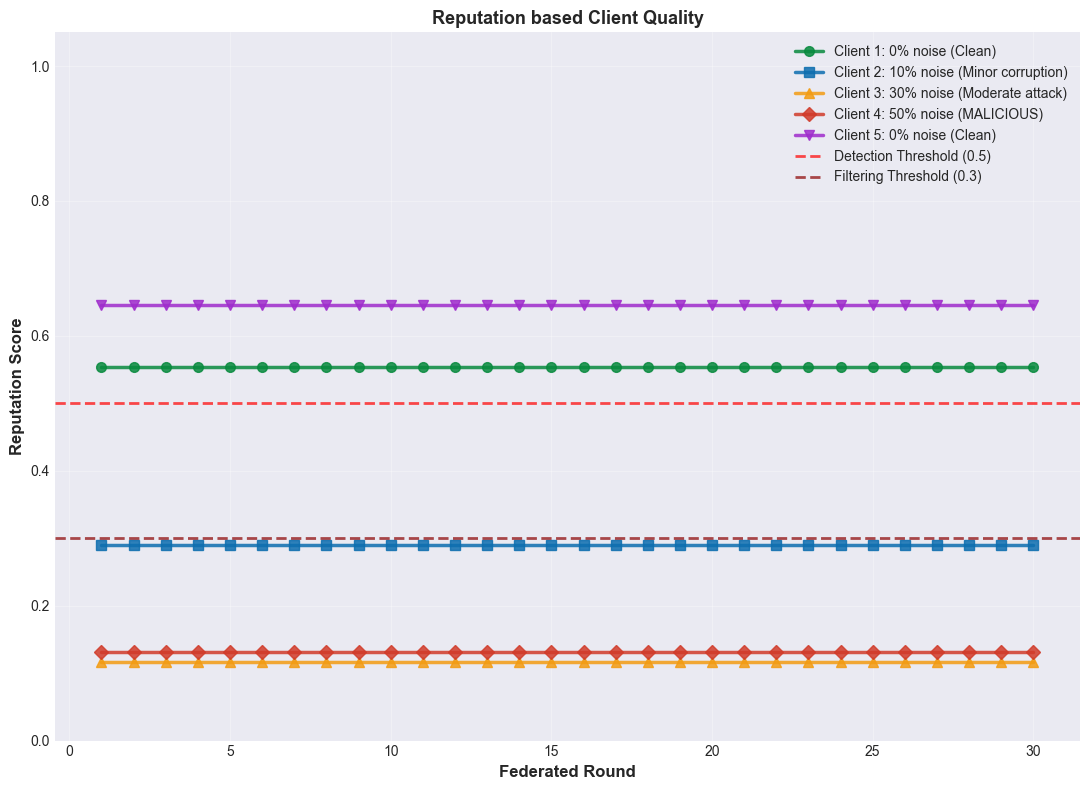

Figure 3: Noise Level vs Final Reputation...
  ✓ Saved: fig3_noise_reputation_correlation.png


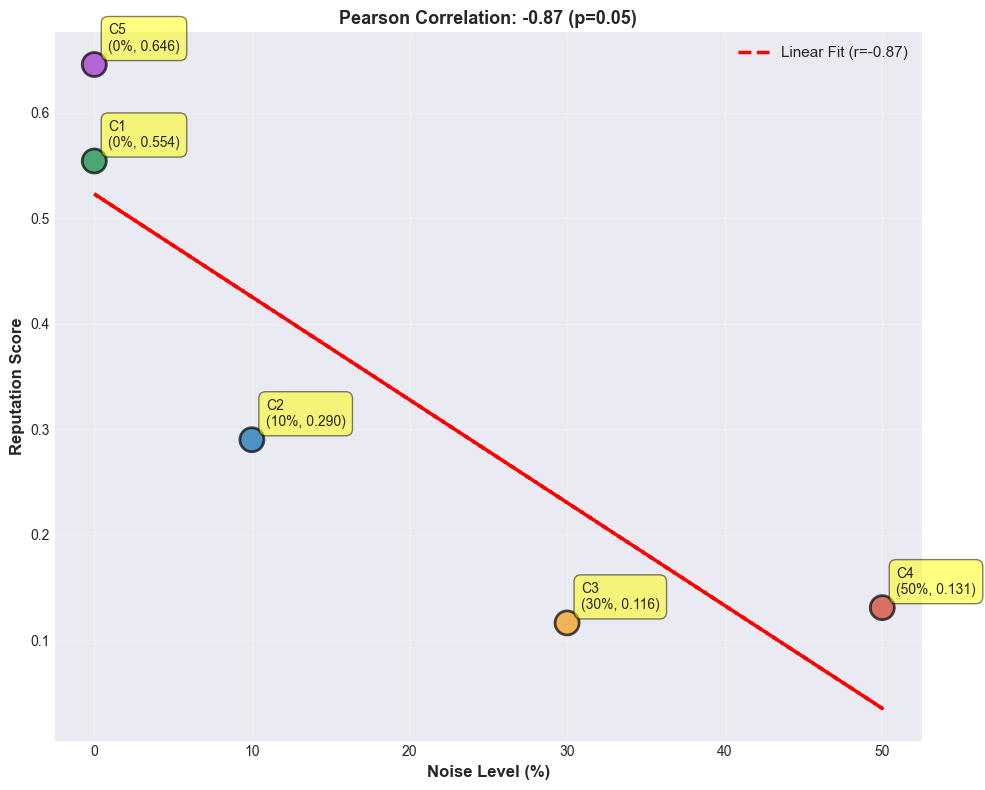

Generating Figure 8: Client Participation Analysis...
  ✓ Saved: fig8_client_participation.png


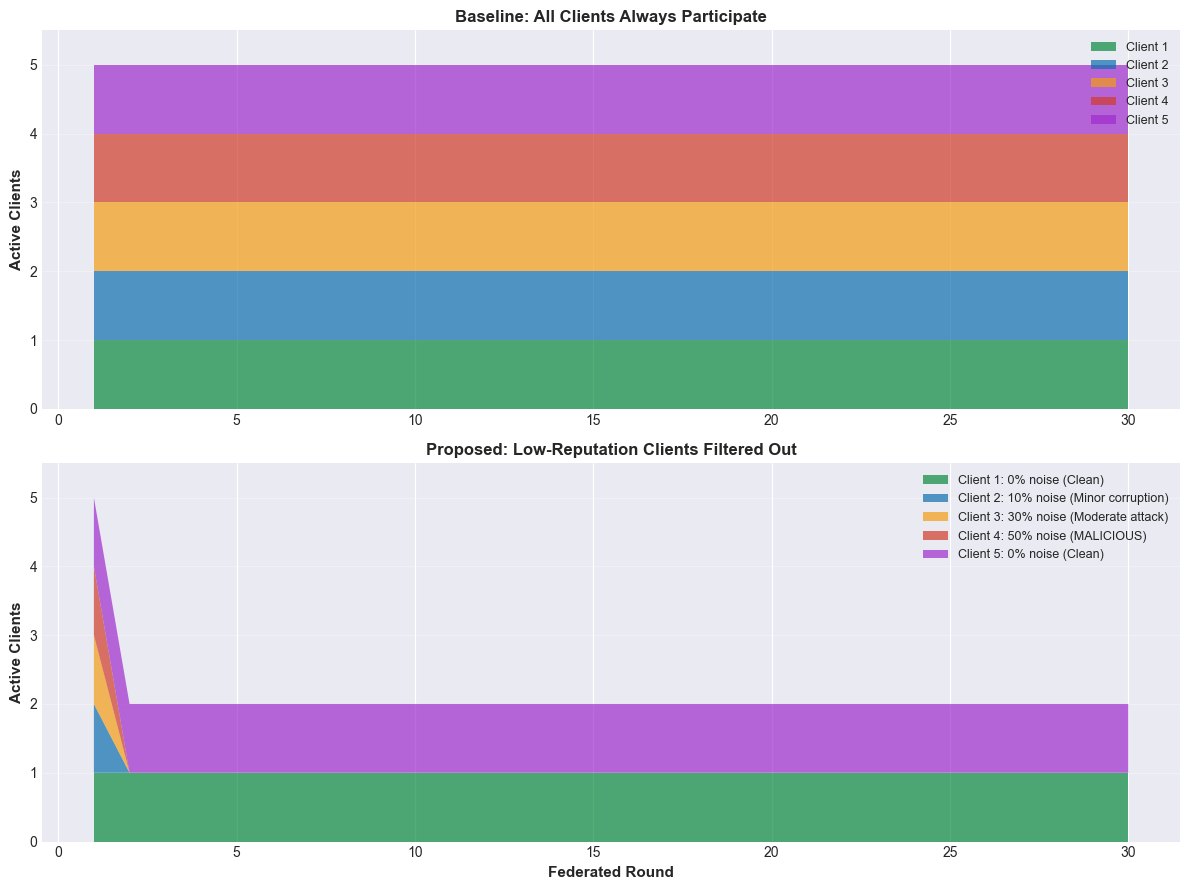

In [3]:
# ===================================================================
# FIGURE 2: Client Reputation Evolution
# ===================================================================
print("Figure 2: Client Reputation Evolution...")
fig2, ax = plt.subplots(1, 1, figsize=(11, 8))


colors = ["#088a3e", "#0d6eaf", '#f39c12', "#d13b2a", "#9f2ccc"]
markers = ['o', 's', '^', 'D', 'v']
client_labels = [
    'Client 1: 0% noise (Clean)',
    'Client 2: 10% noise (Minor corruption)',
    'Client 3: 30% noise (Moderate attack)',
    'Client 4: 50% noise (MALICIOUS)',
    'Client 5: 0% noise (Clean)'
]


for cid in range(1, 6):
    reps = results_reputation['reputations'][cid]
    ax.plot(rounds_axis, reps, marker=markers[cid-1], 
            label=client_labels[cid-1], linewidth=2.5, 
            markersize=7, color=colors[cid-1], alpha=0.85)

ax.axhline(y=0.5, color='red', linestyle='--', linewidth=2, 
           label='Detection Threshold (0.5)', alpha=0.7)
ax.axhline(y=0.3, color='darkred', linestyle='--', linewidth=2, 
           label='Filtering Threshold (0.3)', alpha=0.7)
ax.set_xlabel('Federated Round', fontsize=12, fontweight='bold')
ax.set_ylabel('Reputation Score', fontsize=12, fontweight='bold')
ax.set_title('Reputation based Client Quality', fontsize=13, fontweight='bold')
ax.legend(loc='best', fontsize=10, framealpha=0.9)
ax.grid(True, alpha=0.3)
ax.set_ylim([0, 1.05])

plt.tight_layout()
plt.savefig('fig2_reputation_evolution.png', dpi=300, bbox_inches='tight')
print("  ✓ Saved: fig2_reputation_evolution.png")
plt.show()



# ===================================================================
# FIGURE 3: Noise vs Reputation Correlation
# ===================================================================
print("Figure 3: Noise Level vs Final Reputation...")
fig3, ax = plt.subplots(1, 1, figsize=(10, 8))

ax.scatter(np.array(noise_levels)*100, final_reputations, 
           s=300, c=colors, alpha=0.7, edgecolors='black', linewidth=2)

# Add labels for each point
for i, (noise, rep) in enumerate(zip(noise_levels, final_reputations)):
    ax.annotate(f'C{i+1}\n({noise*100:.0f}%, {rep:.3f})', 
                xy=(noise*100, rep), xytext=(10, 10),
                textcoords='offset points', fontsize=10, 
                bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5))

# Fit line
z = np.polyfit(np.array(noise_levels)*100, final_reputations, 1)
p = np.poly1d(z)
ax.plot(np.array(noise_levels)*100, p(np.array(noise_levels)*100), 
        "r--", linewidth=2.5, label=f'Linear Fit (r={pearson_corr:.2f})')

ax.set_xlabel('Noise Level (%)', fontsize=12, fontweight='bold')
ax.set_ylabel('Reputation Score', fontsize=12, fontweight='bold')
ax.set_title(f'Pearson Correlation: {pearson_corr:.2f} (p={pearson_p:.2f})', 
             fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('fig3_noise_reputation_correlation.png', dpi=300, bbox_inches='tight')
print("  ✓ Saved: fig3_noise_reputation_correlation.png")
plt.show()


# ===================================================================
# FIGURE 8: Client Participation Over Time
# ===================================================================
print("Generating Figure 8: Client Participation Analysis...")
fig8, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 9))


# Stacked area chart for baseline
baseline_participation = np.array([results_baseline['participation'][i] 
                                   for i in range(1, 6)])
ax1.stackplot(rounds_axis, baseline_participation, 
              labels=[f'Client {i}' for i in range(1, 6)],
              colors=colors, alpha=0.7)
ax1.set_ylabel('Active Clients', fontsize=11, fontweight='bold')
ax1.set_title('Baseline: All Clients Always Participate', fontsize=12, fontweight='bold')
ax1.legend(loc='upper right', fontsize=9)
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_ylim([0, 5.5])

# Stacked area chart for reputation-based
reputation_participation = np.array([results_reputation['participation'][i] 
                                      for i in range(1, 6)])
ax2.stackplot(rounds_axis, reputation_participation, 
              labels=client_labels,
              colors=colors, alpha=0.7)
ax2.set_xlabel('Federated Round', fontsize=11, fontweight='bold')
ax2.set_ylabel('Active Clients', fontsize=11, fontweight='bold')
ax2.set_title('Proposed: Low-Reputation Clients Filtered Out', fontsize=12, fontweight='bold')
ax2.legend(loc='upper right', fontsize=9)
ax2.grid(True, alpha=0.3, axis='y')
ax2.set_ylim([0, 5.5])

plt.tight_layout()
plt.savefig('fig8_client_participation.png', dpi=300, bbox_inches='tight')
print("  ✓ Saved: fig8_client_participation.png")
plt.show()